# Conditional Diffusion MNIST Pixel Distribution Analysis

## Introduction

This document is intended to check how identical the distribution diagram of the image used for learning is to the distribution diagram generated by the deep learing model. I hope this improves your understanding of DDPM.

## Resource

- Code: https://github.com/TeaPearce/Conditional_Diffusion_MNIST/tree/main
- DDPM Architecture: https://velog.io/@sihyeong671/DDPM-%EC%9D%B4%ED%95%B4%ED%95%B4%EB%B3%B4%EA%B8%B0

### Code

In [12]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from torchvision.transforms.functional import to_pil_image

In [2]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

In [3]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [4]:
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [5]:
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [6]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7), # otherwise just have 2*n_feat
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t, context_mask):
        # x is (noisy) image, c is context label, t is timestep, 
        # context_mask says which samples to block the context on

        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        # convert context to one hot embedding
        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)
        
        # mask out context if context_mask == 1
        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1,self.n_classes)
        context_mask = (-1*(1-context_mask)) # need to flip 0 <-> 1
        c = c * context_mask
        
        # embed context, time step
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)

        up1 = self.up0(hiddenvec)
        # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
        up2 = self.up1(cemb1*up1+ temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

In [7]:
def ddpm_schedules(beta1, beta2, T):
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

In [8]:
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """
        this method is used in training, so samples t and noise randomly
        """

        _ts = torch.randint(1, self.n_T+1, (x.shape[0],)).to(self.device)  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c)+self.drop_prob).to(self.device)
        
        # return MSE between added noise, and our predicted noise
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T, context_mask))

    def sample(self, n_sample, size, device, guide_w = 0.0):
        # we follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
        # to make the fwd passes efficient, we concat two versions of the dataset,
        # one with context_mask=0 and the other context_mask=1
        # we then mix the outputs with the guidance scale, w
        # where w>0 means more guidance

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1), sample initial noise
        c_i = torch.arange(0,10).to(device) # context for us just cycles throught the mnist labels
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

        # don't drop context at test time
        context_mask = torch.zeros_like(c_i).to(device)

        # double the batch
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1. # makes second half of batch context free

        x_i_store = [] # keep track of generated steps in case want to plot something 
        print()
        for i in range(self.n_T, 0, -1):
            print(f'sampling timestep {i}',end='\r')
            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_sample,1,1,1)

            # double batch
            x_i = x_i.repeat(2,1,1,1)
            t_is = t_is.repeat(2,1,1,1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]
            eps = (1+guide_w)*eps1 - guide_w*eps2
            x_i = x_i[:n_sample]
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i%20==0 or i==self.n_T or i<8:
                x_i_store.append(x_i.detach().cpu().numpy())
        
        x_i_store = np.array(x_i_store)
        return x_i, x_i_store

In [9]:
def train_mnist():

    # hardcoding these here
    n_epoch = 20
    batch_size = 256
    n_T = 400 # 500
    device = "cuda:0"
    n_classes = 10
    n_feat = 128 # 128 ok, 256 better (but slower)
    lrate = 1e-4
    save_model = False
    save_dir = './data/diffusion_outputs10/'
    ws_test = [0.0, 0.5, 2.0] # strength of generative guidance

    ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=n_classes), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
    ddpm.to(device)

    # optionally load a model
    # ddpm.load_state_dict(torch.load("./data/diffusion_outputs/ddpm_unet01_mnist_9.pth"))

    tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

    dataset = MNIST("./data", train=True, download=True, transform=tf)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=5)
    optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)

    for ep in range(n_epoch):
        print(f'epoch {ep}')
        ddpm.train()

        # linear lrate decay
        optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

        pbar = tqdm(dataloader)
        loss_ema = None
        for x, c in pbar:
            optim.zero_grad()
            x = x.to(device)
            c = c.to(device)
            loss = ddpm(x, c)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()
        
        # for eval, save an image of currently generated samples (top rows)
        # followed by real images (bottom rows)
        ddpm.eval()
        with torch.no_grad():
            n_sample = 4*n_classes
            for w_i, w in enumerate(ws_test):
                x_gen, x_gen_store = ddpm.sample(n_sample, (1, 28, 28), device, guide_w=w)

                # append some real images at bottom, order by class also
                x_real = torch.Tensor(x_gen.shape).to(device)
                for k in range(n_classes):
                    for j in range(int(n_sample/n_classes)):
                        try: 
                            idx = torch.squeeze((c == k).nonzero())[j]
                        except:
                            idx = 0
                        x_real[k+(j*n_classes)] = x[idx]

                x_all = torch.cat([x_gen, x_real])
                grid = make_grid(x_all*-1 + 1, nrow=10)
                save_image(grid, save_dir + f"image_ep{ep}_w{w}.png")
                print('saved image at ' + save_dir + f"image_ep{ep}_w{w}.png")

                if ep%5==0 or ep == int(n_epoch-1):
                    # create gif of images evolving over time, based on x_gen_store
                    fig, axs = plt.subplots(nrows=int(n_sample/n_classes), ncols=n_classes,sharex=True,sharey=True,figsize=(8,3))
                    def animate_diff(i, x_gen_store):
                        print(f'gif animating frame {i} of {x_gen_store.shape[0]}', end='\r')
                        plots = []
                        for row in range(int(n_sample/n_classes)):
                            for col in range(n_classes):
                                axs[row, col].clear()
                                axs[row, col].set_xticks([])
                                axs[row, col].set_yticks([])
                                # plots.append(axs[row, col].imshow(x_gen_store[i,(row*n_classes)+col,0],cmap='gray'))
                                plots.append(axs[row, col].imshow(-x_gen_store[i,(row*n_classes)+col,0],cmap='gray',vmin=(-x_gen_store[i]).min(), vmax=(-x_gen_store[i]).max()))
                        return plots
                    ani = FuncAnimation(fig, animate_diff, fargs=[x_gen_store],  interval=200, blit=False, repeat=True, frames=x_gen_store.shape[0])    
                    ani.save(save_dir + f"gif_ep{ep}_w{w}.gif", dpi=100, writer=PillowWriter(fps=5))
                    print('saved image at ' + save_dir + f"gif_ep{ep}_w{w}.gif")
        # optionally save model
        if save_model and ep == int(n_epoch-1):
            torch.save(ddpm.state_dict(), save_dir + f"model_{ep}.pth")
            print('saved model at ' + save_dir + f"model_{ep}.pth")

# if __name__ == "__main__":
#     train_mnist()

### How the Matrix Changes For Learning

#### Common Code

In [10]:
# hardcoding these here
n_epoch = 20
batch_size = 256
n_T = 400 # 500
device = "cuda:0"
n_classes = 10
n_feat = 128 # 128 ok, 256 better (but slower)
lrate = 1e-4
save_model = False
save_dir = './data/diffusion_outputs10/'
ws_test = [0.0, 0.5, 2.0] # strength of generative guidance

# ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=n_classes), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
# ddpm.to(device)

tf = transforms.Compose([transforms.ToTensor()])
mnist_dataset = MNIST("./data", train=True, download=True, transform=tf)

x = mnist_dataset[0][0] # tensor(28, 28)
y = mnist_dataset[0][1] # 5
print("label: ", y) # label
print("data shape:", x.shape) # shape of tensor

label:  5
data shape: torch.Size([1, 28, 28])


In [14]:
# Visualization
def channel_visualization(title_name:str, output):
  # 출력 데이터를 NumPy 배열로 변환
  output_np = output.detach().numpy()

  # 채널별 이미지 생성 및 그리드 형태 배치
  num_channels = output_np.shape[1]
  fig, axes = plt.subplots(nrows=16, ncols=8, figsize=(16, 16))

  for i, ax in enumerate(axes.flat):
      if i < num_channels:
          ax.imshow(output_np[0, i, :, :], cmap='gray')
          ax.axis('off')
      else:
          ax.axis('off')

  plt.title(title_name)
  plt.tight_layout()
  plt.show()

#### Noise and Context Mask

_ts shape:  torch.Size([1])
_ts:  tensor([100])
noise shape:  torch.Size([1, 28, 28])
noise[0][0][0]:  tensor(-2.0132)
sqrtab[_ts, None, None, None]:  tensor([[[[0.8773]]]])
sqrtmab[_ts, None, None, None]:  tensor([[[[0.4799]]]])
x_t shape:  torch.Size([1, 1, 28, 28])
x_t[0][0][0][0]:  tensor(-0.9662)  / noise[0][0][0]:  tensor(-2.0132)  / _ts[0]:  tensor(100)
context_mask:  tensor([0.])
context_mask shape:  torch.Size([1])
c:  tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])
new c (flip) = c * context_mask:  tensor([[-0., -0., -0., -0., -0., -1., -0., -0., -0., -0.]])


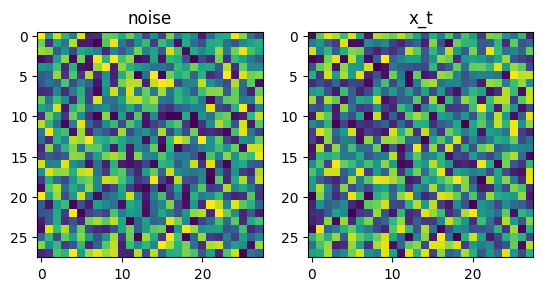

In [13]:
_ts = torch.randint(1, n_T+1, (x.shape[0],))  # t ~ Uniform(0, n_T)
noise = torch.randn_like(x)  # eps ~ N(0, 1)

print("_ts shape: ", _ts.shape)
print("_ts: ", _ts)

print("noise shape: ", noise.shape)
print("noise[0][0][0]: ", noise[0][0][0])

# plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(noise))
plt.title('noise')

betas=(1e-4, 0.02)
beta1, beta2 = betas[0], betas[1]
beta_t = (beta2 - beta1) * torch.arange(0, n_T + 1, dtype=torch.float32) / n_T + beta1
sqrt_beta_t = torch.sqrt(beta_t)
alpha_t = 1 - beta_t
log_alpha_t = torch.log(alpha_t)
alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()
sqrtab = torch.sqrt(alphabar_t)
sqrtmab = torch.sqrt(1 - alphabar_t)
mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

x_t = (
    sqrtab[_ts, None, None, None] * x
    + sqrtmab[_ts, None, None, None] * noise
)
print("sqrtab[_ts, None, None, None]: ", sqrtab[_ts, None, None, None])
print("sqrtmab[_ts, None, None, None]: ", sqrtmab[_ts, None, None, None]) 
print("x_t shape: ", x_t.shape)
# print("x_t: ", x_t)
print("x_t[0][0][0][0]: ", x_t[0][0][0][0], " / noise[0][0][0]: ", noise[0][0][0], " / _ts[0]: ", _ts[0])

plt.subplot(1,2,2)
plt.imshow(to_pil_image(x_t[0][0]))
plt.title('x_t')

# dropout context with some probability
drop_prob=0.1
y_tensor = torch.Tensor([y])
context_mask = torch.bernoulli(torch.zeros_like(y_tensor) + drop_prob)
print("context_mask: ", context_mask)
print("context_mask shape: ", context_mask.shape)

# convert context to one hot embedding
c = nn.functional.one_hot(y_tensor.to(torch.int64), num_classes=n_classes).type(torch.float)
print("c: ", c)

# mask out context if context_mask == 1
context_mask = context_mask[:, None]
context_mask = context_mask.repeat(1, n_classes)
context_mask = (-1*(1-context_mask)) # need to flip 0 <-> 1
c = c * context_mask
print("new c (flip) = c * context_mask: ", c)


In [ ]:
# self.nn_model(x_t, c, _ts / self.n_T, context_mask)
# def forward(self, x, c, t, context_mask):
    # x is (noisy) image, c is context label, t is timestep, 
    # context_mask says which samples to block the context on

##### self.init_conv = ResidualConvBlock(in_channels=1, n_feat=128, is_res=True)

x_t1: torch.Size([1, 128, 28, 28])
x_t2: torch.Size([1, 128, 28, 28])
x_t3: torch.Size([1, 128, 28, 28])
x_t1 channels


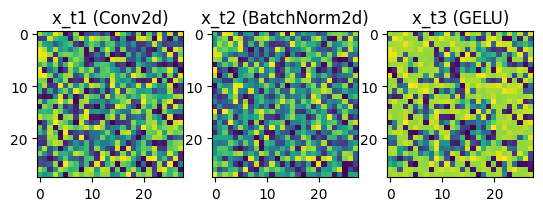

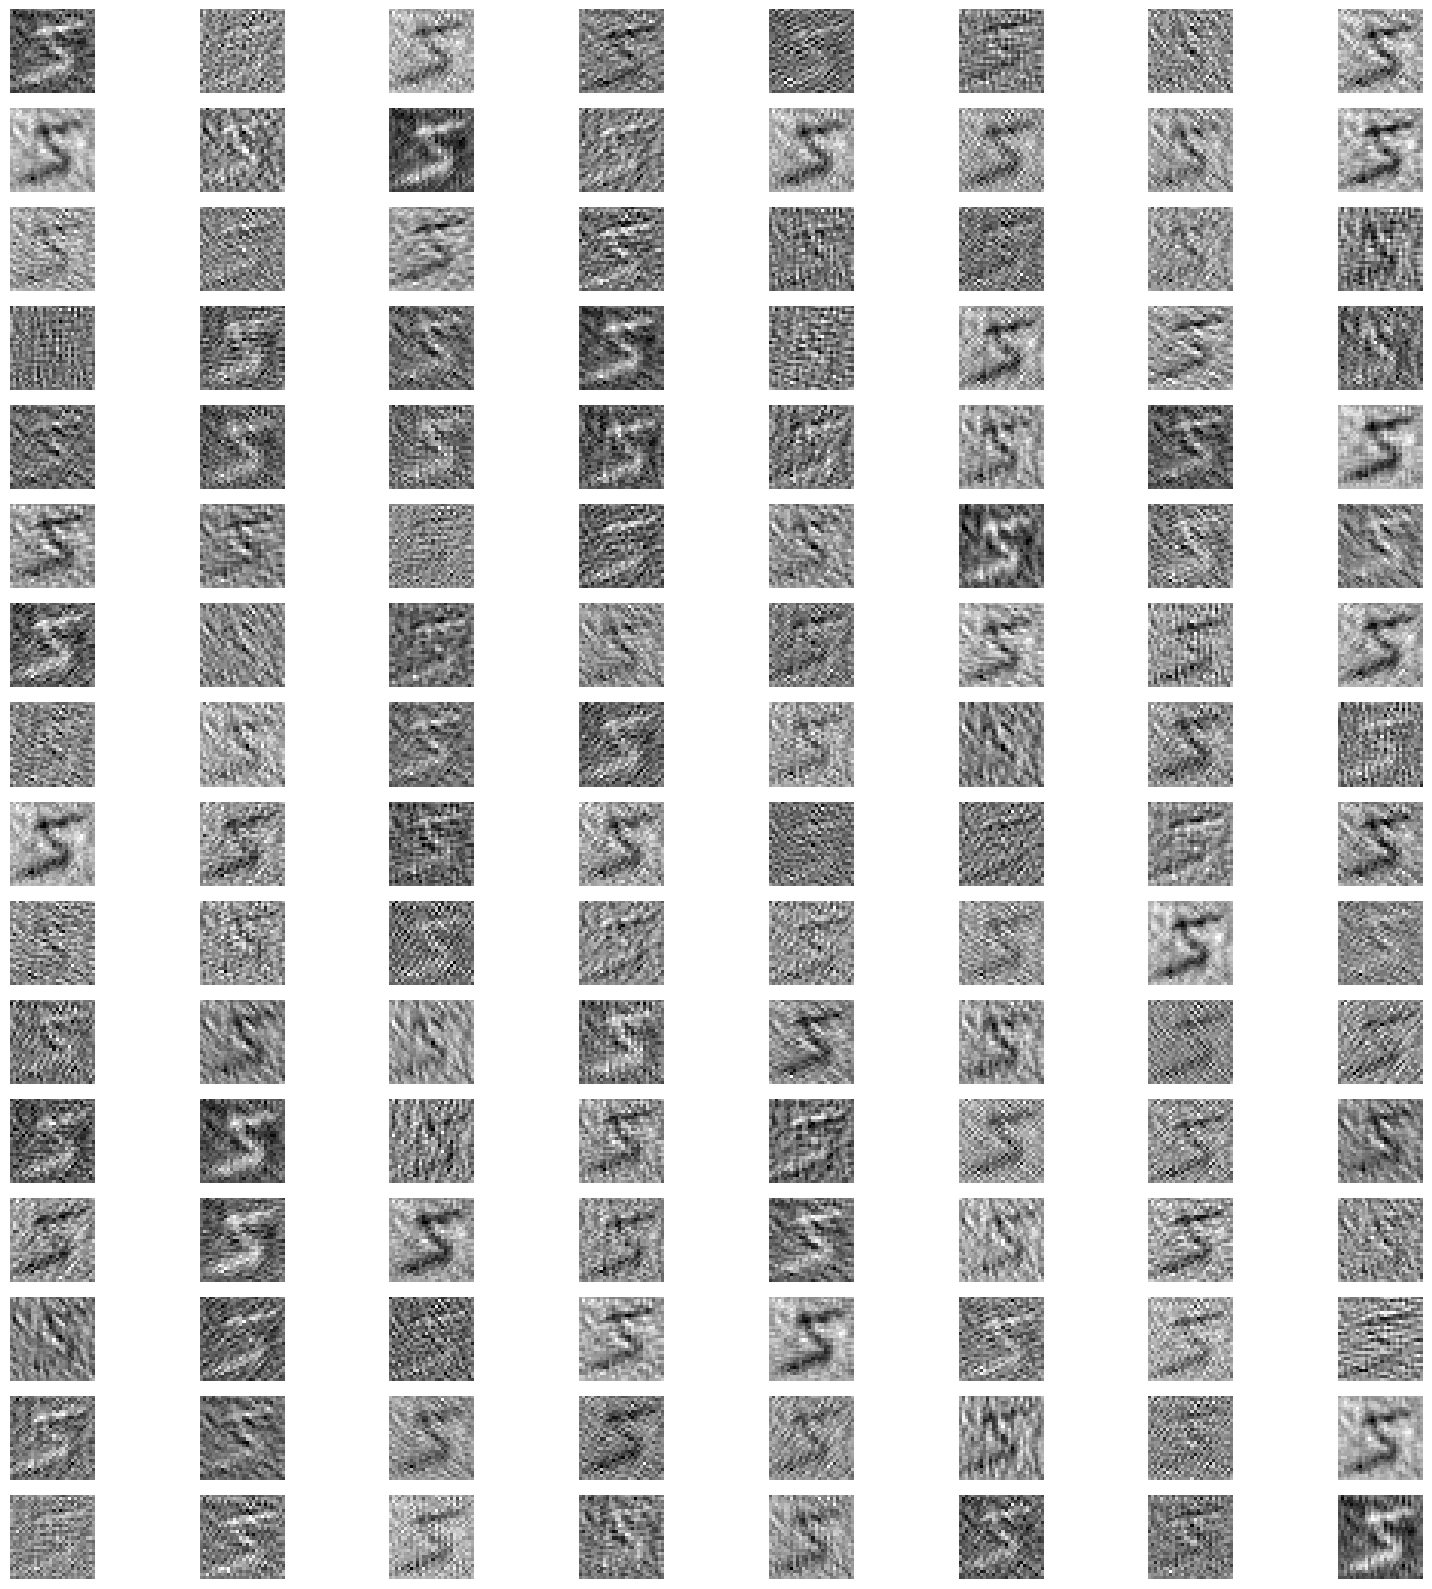

x_t2 channels


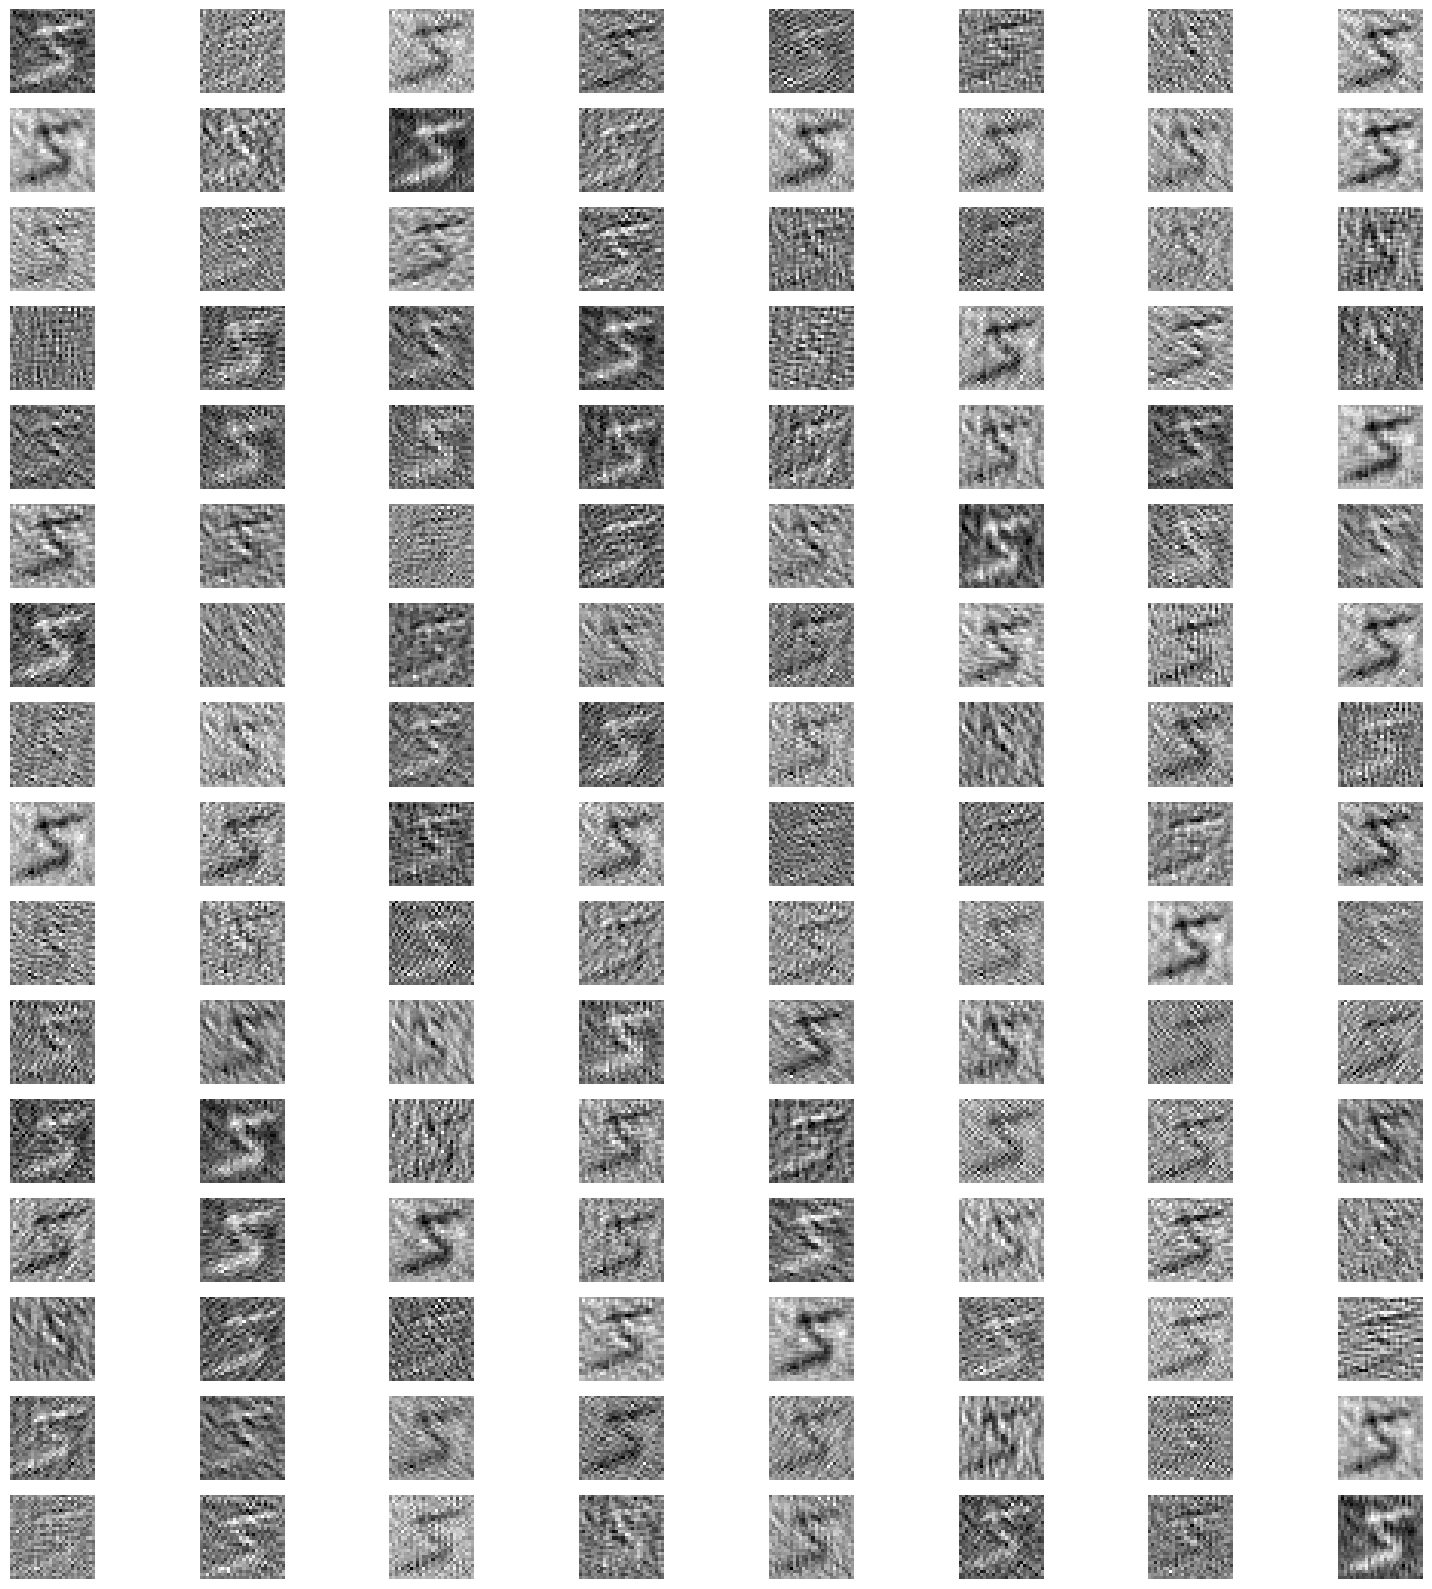

x_t3 channels


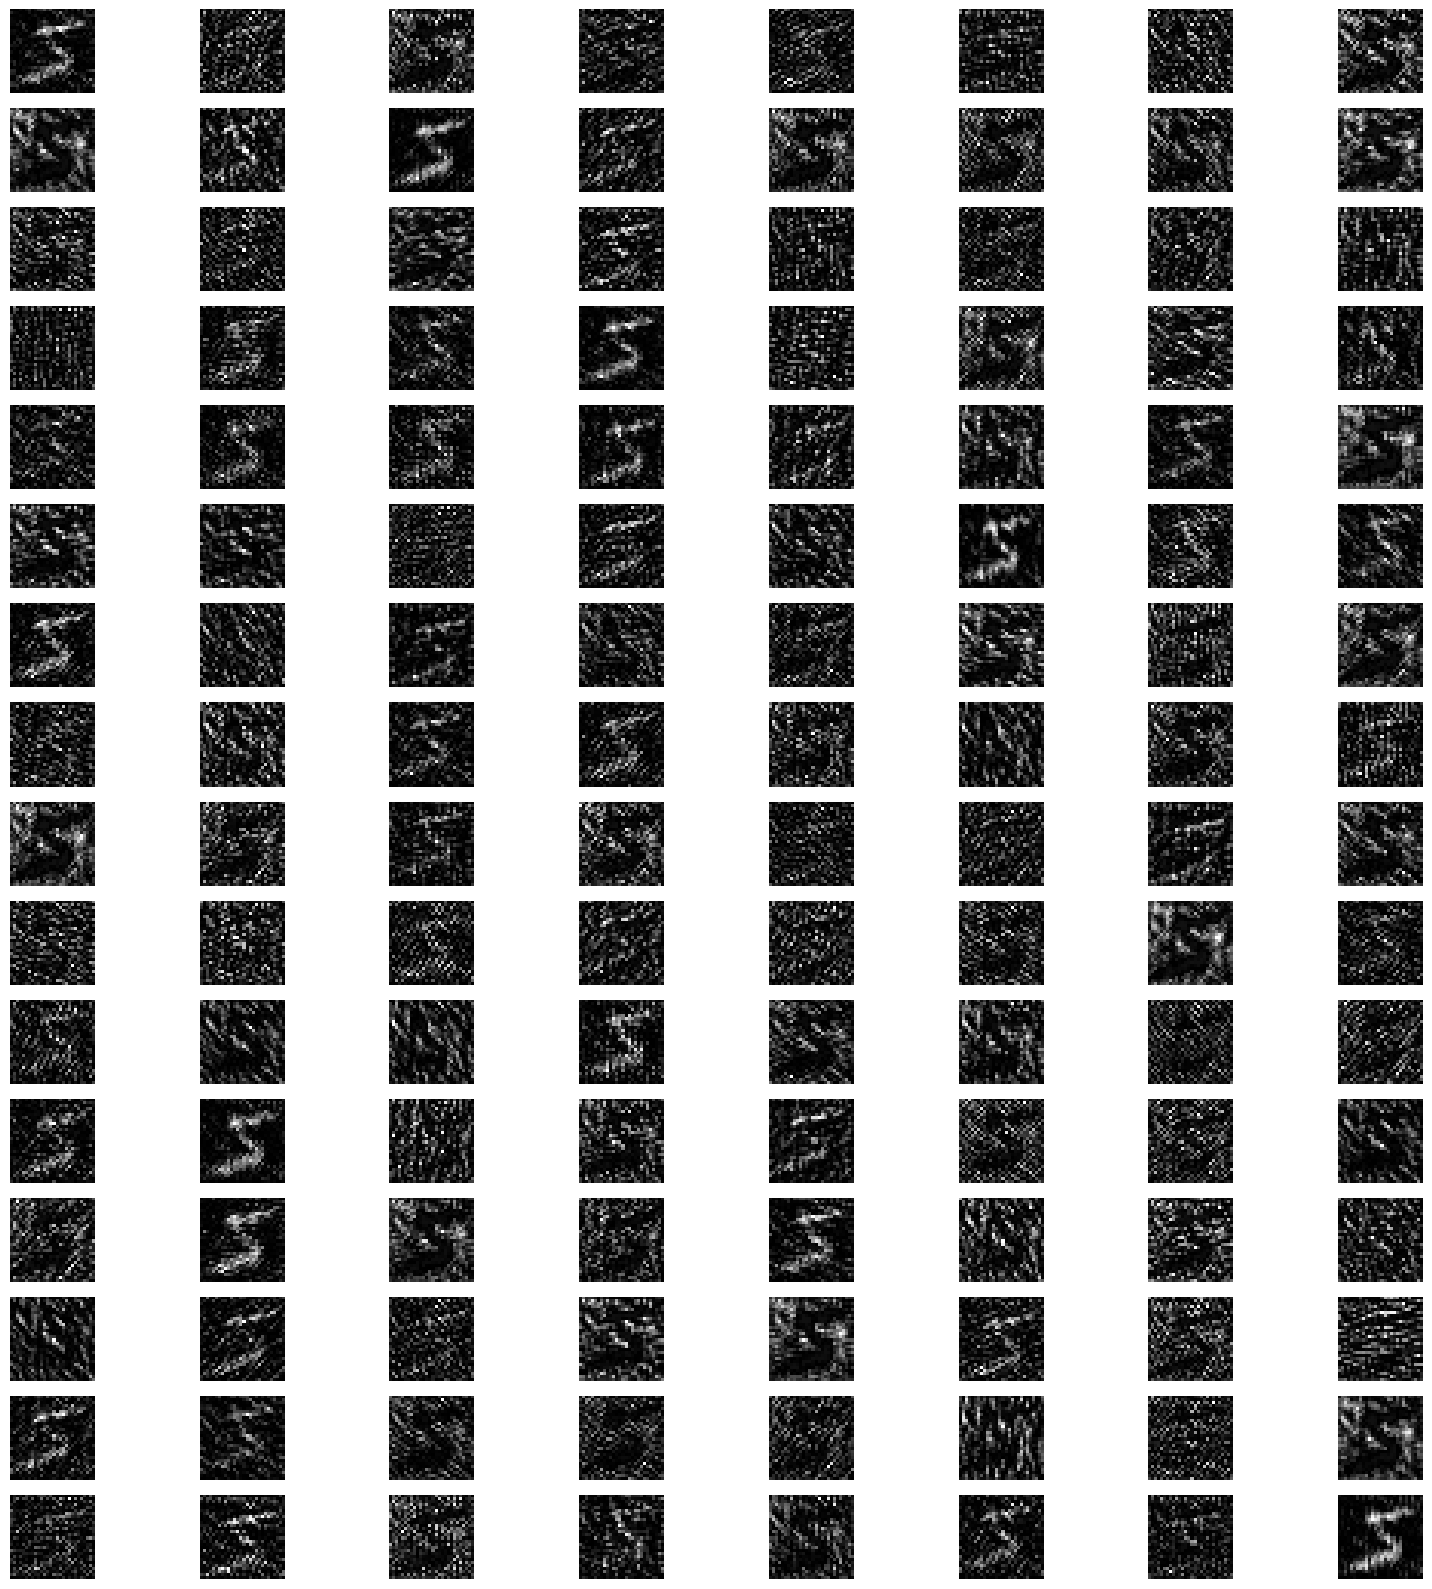

In [15]:
p1 = nn.Conv2d(1, n_feat, 3, 1, 1) # 128
p2 = nn.BatchNorm2d(n_feat) # 128
p3 = nn.GELU()

x_t1 = p1(x_t)
print("x_t1:", x_t1.shape)
plt.subplot(1,3,1)
plt.imshow(to_pil_image(x_t1[0][0]))
plt.title('x_t1 (Conv2d)')

x_t2 = p2(x_t1)
print("x_t2:", x_t2.shape)
plt.subplot(1,3,2)
plt.imshow(to_pil_image(x_t2[0][0]))
plt.title('x_t2 (BatchNorm2d)')

x_t3 = p3(x_t2)
print("x_t3:", x_t3.shape)
plt.subplot(1,3,3)
plt.imshow(to_pil_image(x_t3[0][0]))
plt.title('x_t3 (GELU)')

print("x_t1 channels")
channel_visualization("", x_t1)
print("x_t2 channels")
channel_visualization("", x_t2)
print("x_t3 channels")
channel_visualization("", x_t3)

x_t4: torch.Size([1, 128, 28, 28])
x_t5: torch.Size([1, 128, 28, 28])
x_t6: torch.Size([1, 128, 28, 28])
x_t4 channels


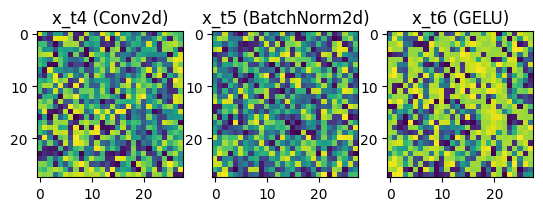

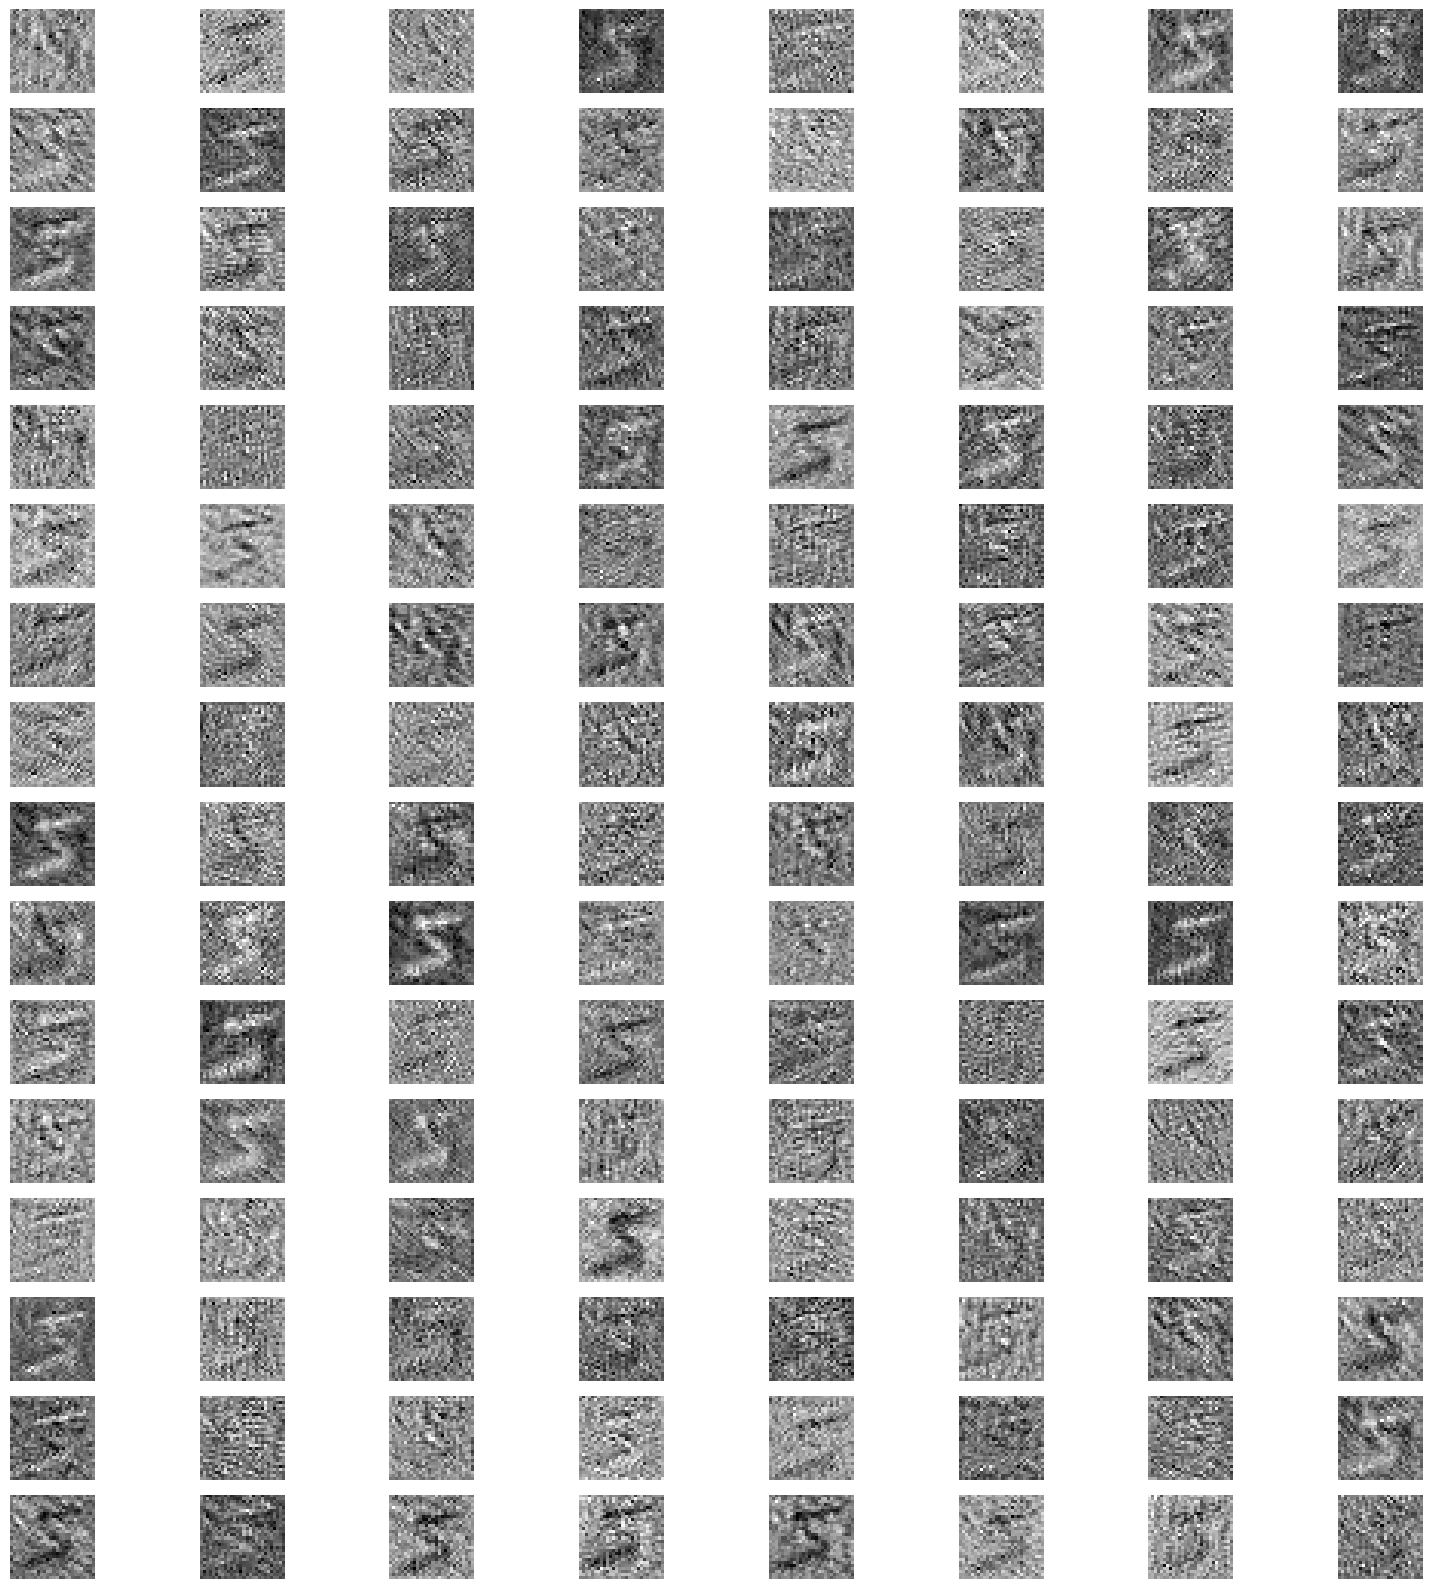

x_t5 channels


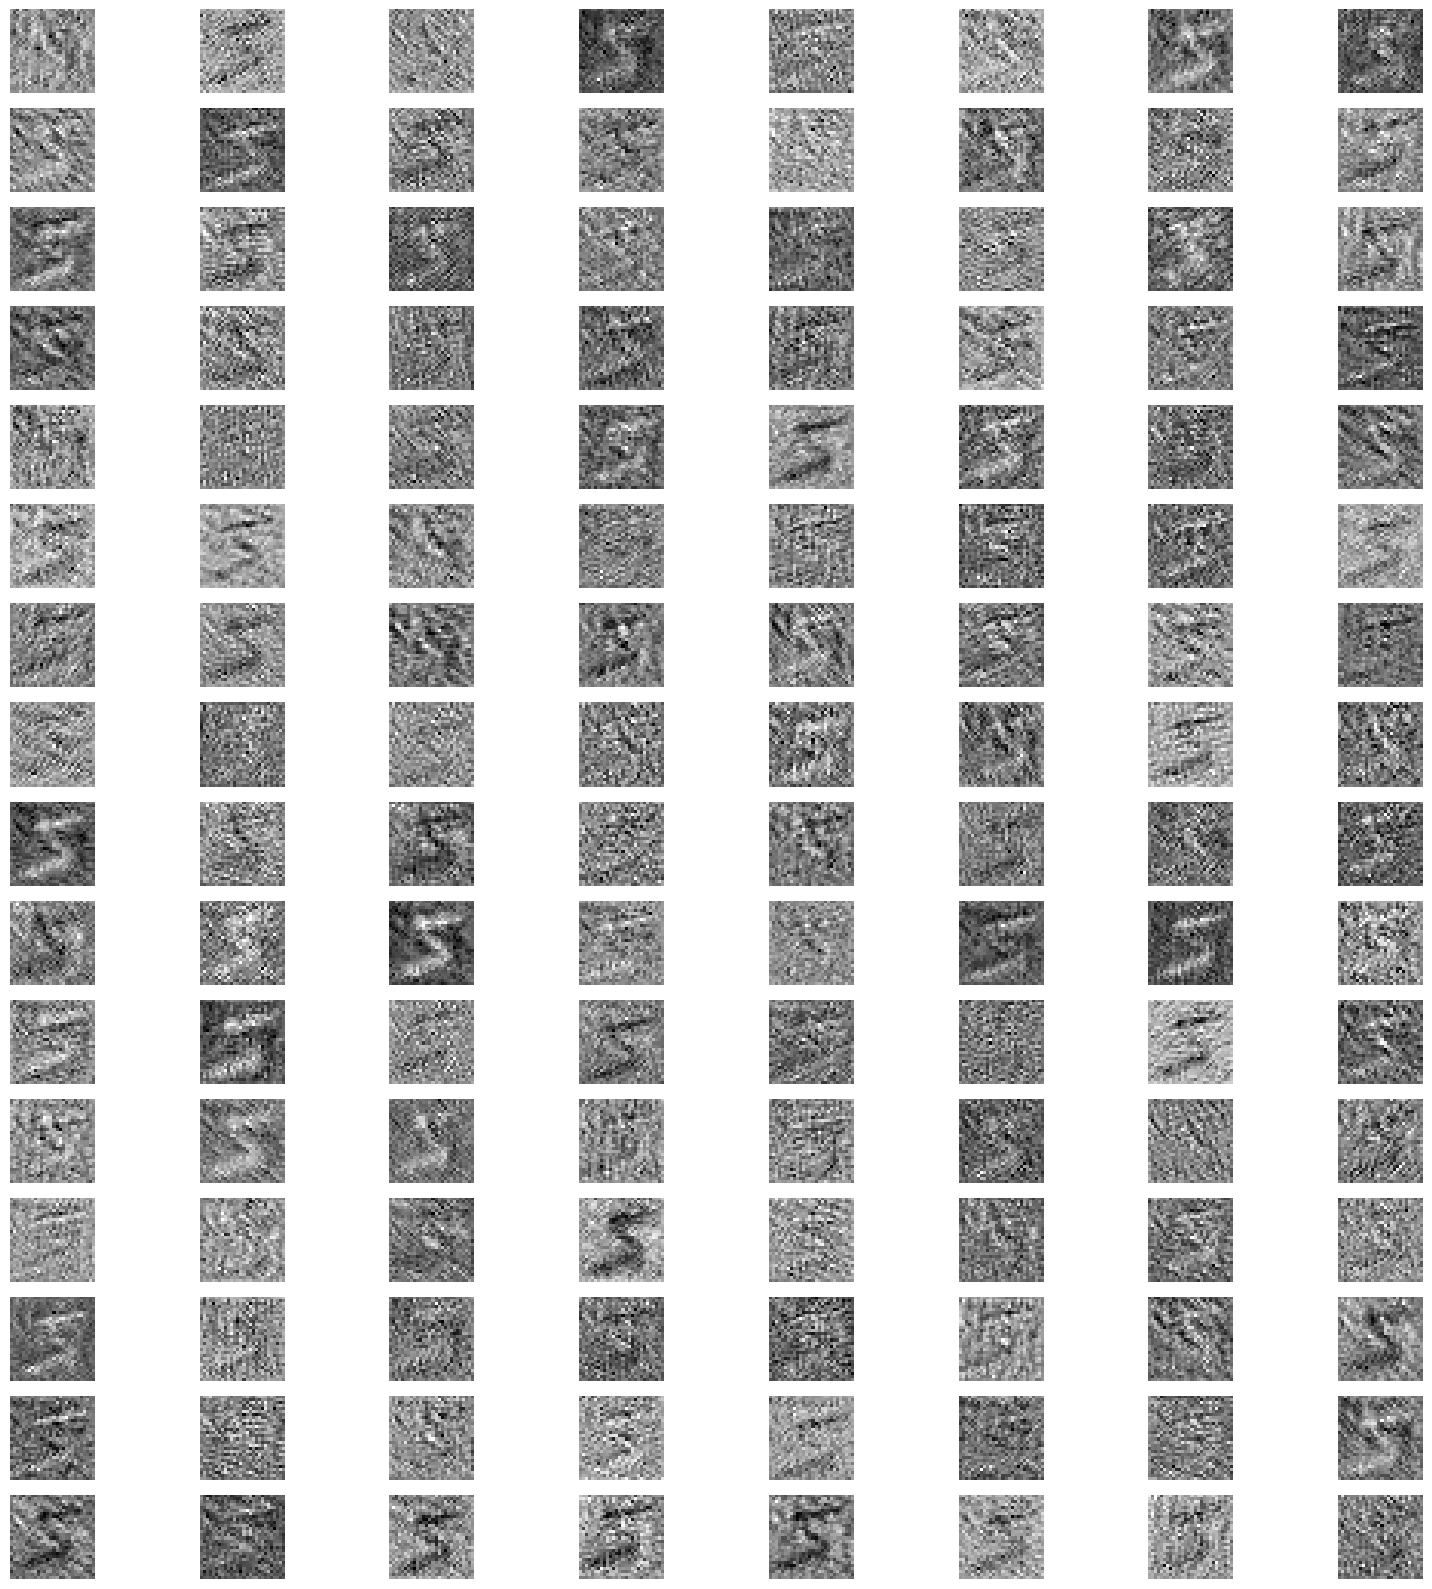

x_t6 channels


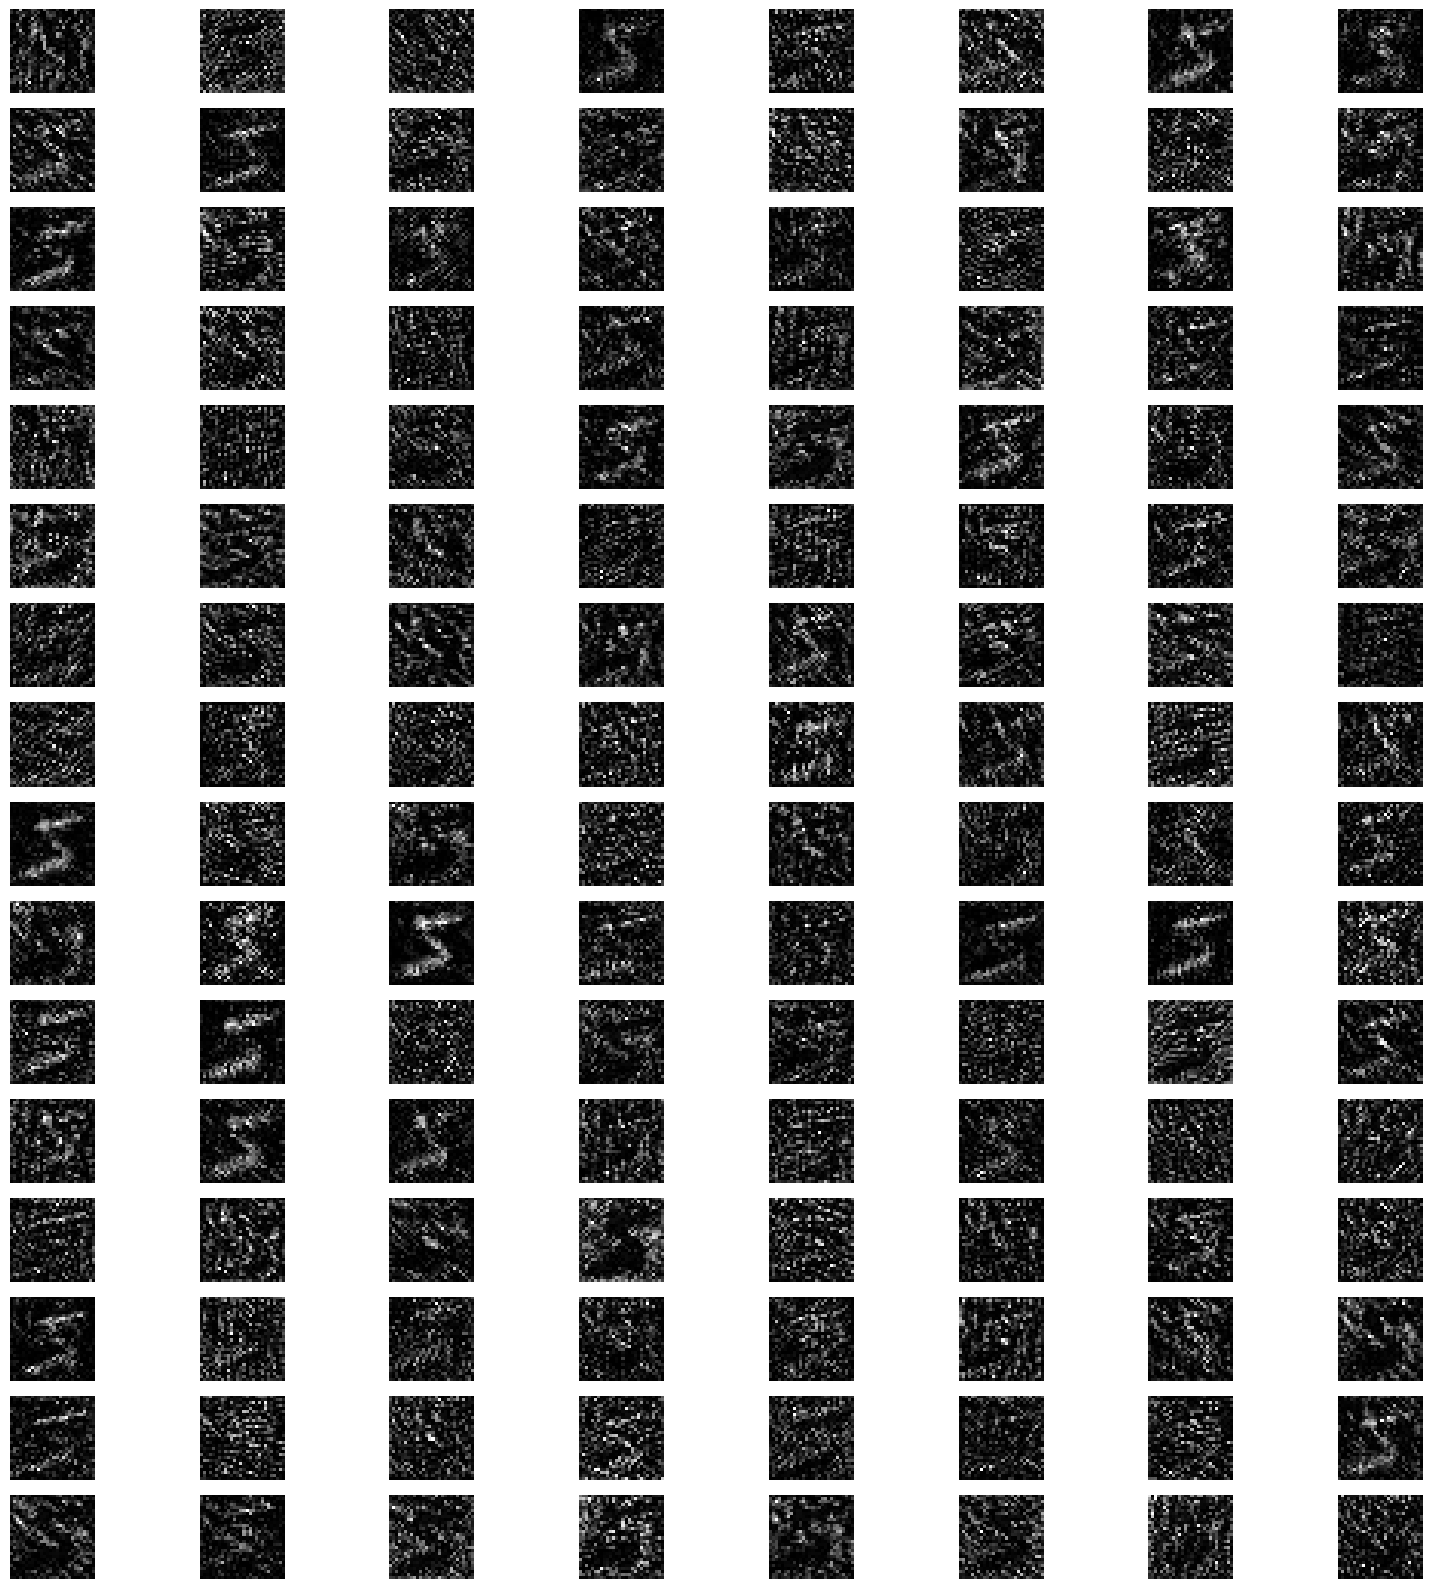

In [16]:
p4 = nn.Conv2d(n_feat, n_feat, 3, 1, 1) # 128
p5 = nn.BatchNorm2d(n_feat) # 128
p6 = nn.GELU()

x_t4 = p4(x_t3)
print("x_t4:", x_t4.shape)
plt.subplot(1,3,1)
plt.imshow(to_pil_image(x_t4[0][0]))
plt.title('x_t4 (Conv2d)')

x_t5 = p5(x_t4)
print("x_t5:", x_t5.shape)
plt.subplot(1,3,2)
plt.imshow(to_pil_image(x_t5[0][0]))
plt.title('x_t5 (BatchNorm2d)')

x_t6 = p6(x_t5)
print("x_t6:", x_t6.shape)
plt.subplot(1,3,3)
plt.imshow(to_pil_image(x_t6[0][0]))
plt.title('x_t6 (GELU)')

print("x_t4 channels")
channel_visualization("", x_t4)
print("x_t5 channels")
channel_visualization("", x_t5)
print("x_t6 channels")
channel_visualization("", x_t6)

init_conv: torch.Size([1, 128, 28, 28])


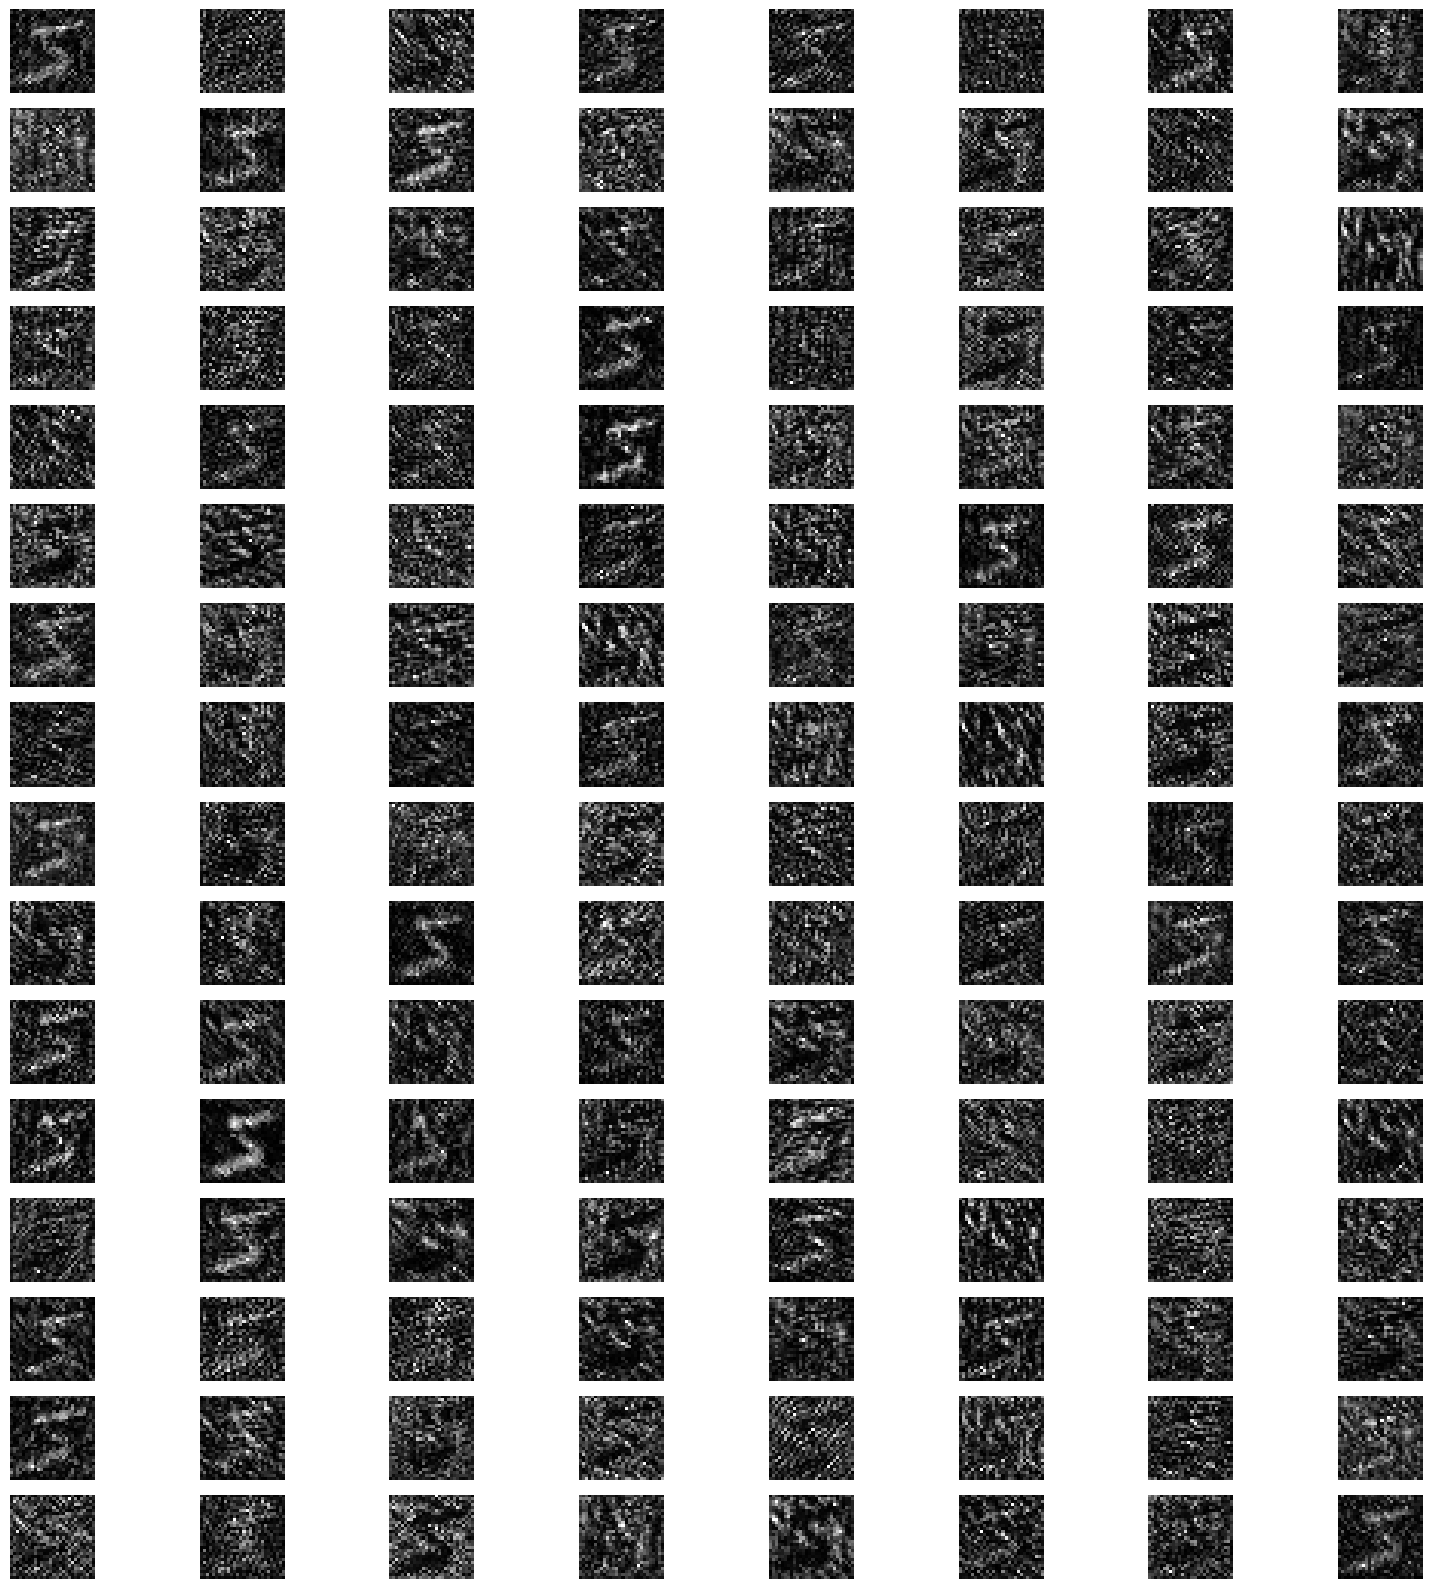

tensor([ 0.1359, -0.3384, -0.1946,  2.3094, -0.2957,  0.0270,  0.4558,  0.5792,
         0.6738,  0.5592,  0.4398,  2.1654,  0.5898,  0.7757, -0.1318,  0.2811,
        -0.3305, -0.2816,  1.8469, -0.2770,  0.0809,  0.8436,  1.1562, -0.2502,
         0.7876, -0.1619,  0.1109, -0.2169], grad_fn=<SelectBackward0>)
init_conv/1.414: torch.Size([1, 128, 28, 28])


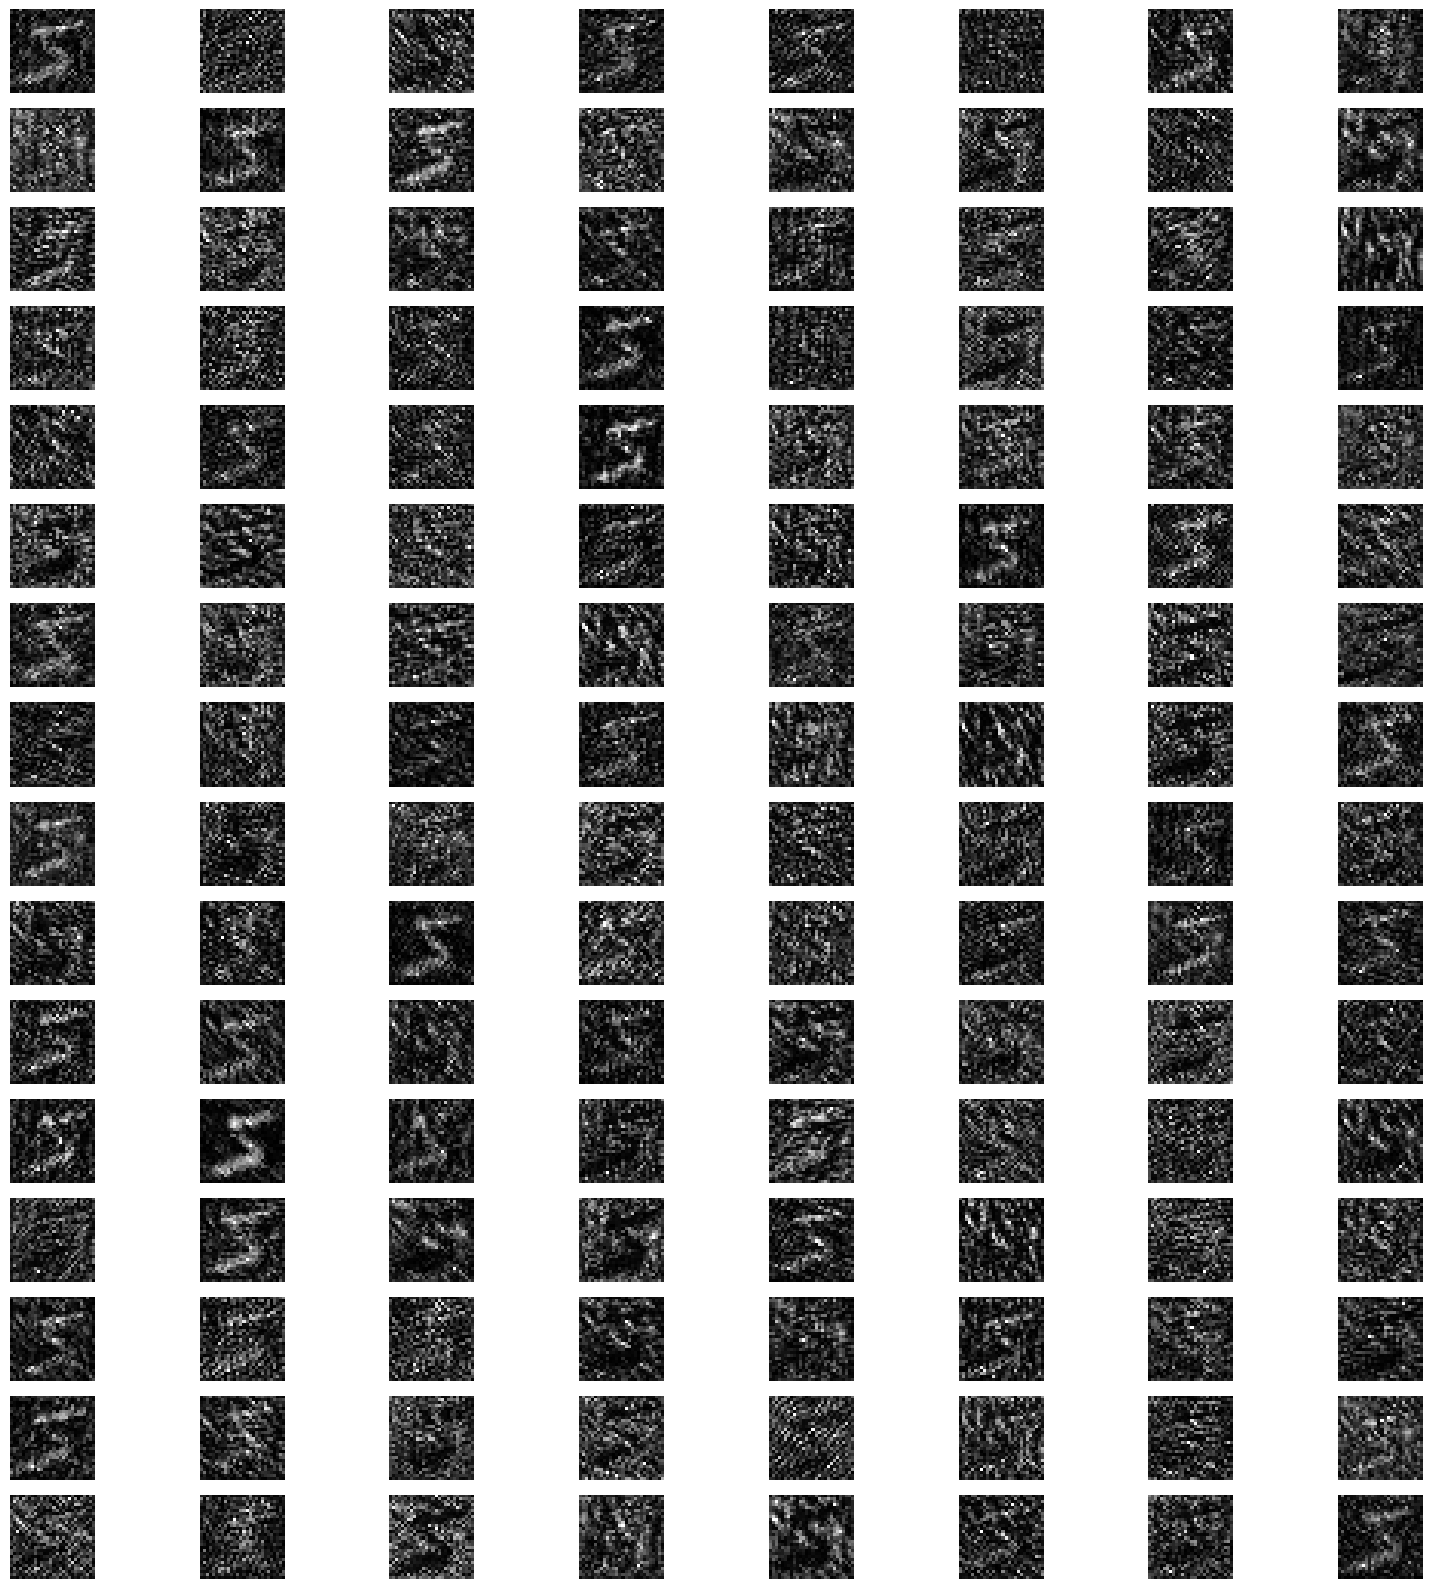

tensor([ 0.0961, -0.2393, -0.1376,  1.6332, -0.2091,  0.0191,  0.3224,  0.4096,
         0.4765,  0.3955,  0.3110,  1.5314,  0.4171,  0.5486, -0.0932,  0.1988,
        -0.2337, -0.1991,  1.3061, -0.1959,  0.0572,  0.5966,  0.8177, -0.1770,
         0.5570, -0.1145,  0.0784, -0.1534], grad_fn=<SelectBackward0>)


In [17]:
# not same channel
init_conv = x_t3 + x_t6
print("init_conv:", init_conv.shape)
channel_visualization("", init_conv)
print(init_conv[0][0][0])

# He 초기화(Kaiming 초기화)
init_conv = init_conv/1.414
print("init_conv/1.414:", init_conv.shape)
channel_visualization("", init_conv)
print(init_conv[0][0][0])

#### UnetDown

##### self.down1 = UnetDown(n_feat=128, n_feat=128)

down1: torch.Size([1, 128, 14, 14])


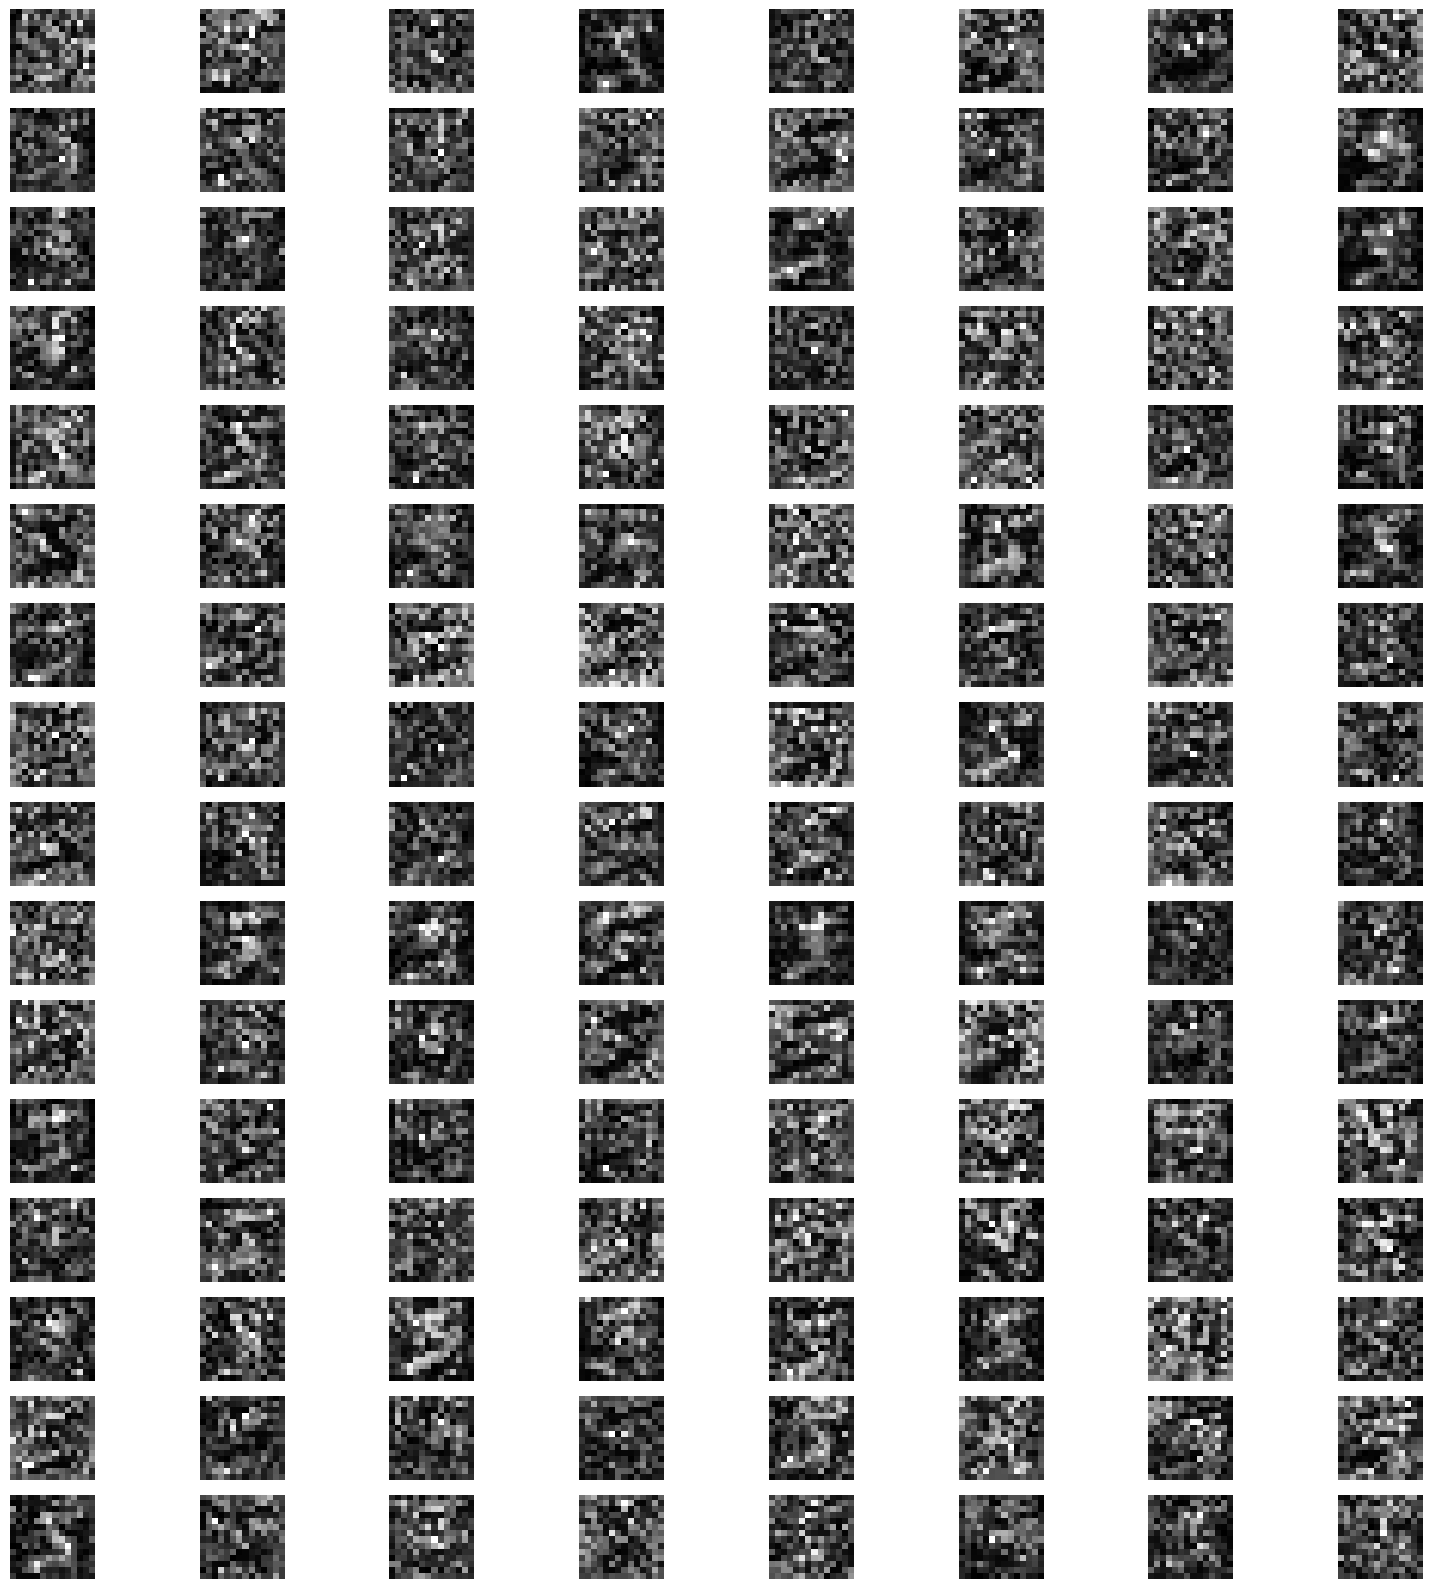

In [18]:
res_conv1 = nn.Sequential(
    nn.Conv2d(n_feat, n_feat, 3, 1, 1),
    nn.BatchNorm2d(n_feat),
    nn.GELU(),
)
res_conv2 = nn.Sequential(
    nn.Conv2d(n_feat, n_feat, 3, 1, 1),
    nn.BatchNorm2d(n_feat),
    nn.GELU(),
)
unet_down1 = nn.MaxPool2d(2)

down1 = unet_down1(res_conv2(res_conv1(init_conv)))
print("down1:", down1.shape)
channel_visualization("", down1)

##### self.down2 = UnetDown(n_feat=128, 2 * n_feat=256)

down1: torch.Size([1, 256, 7, 7])


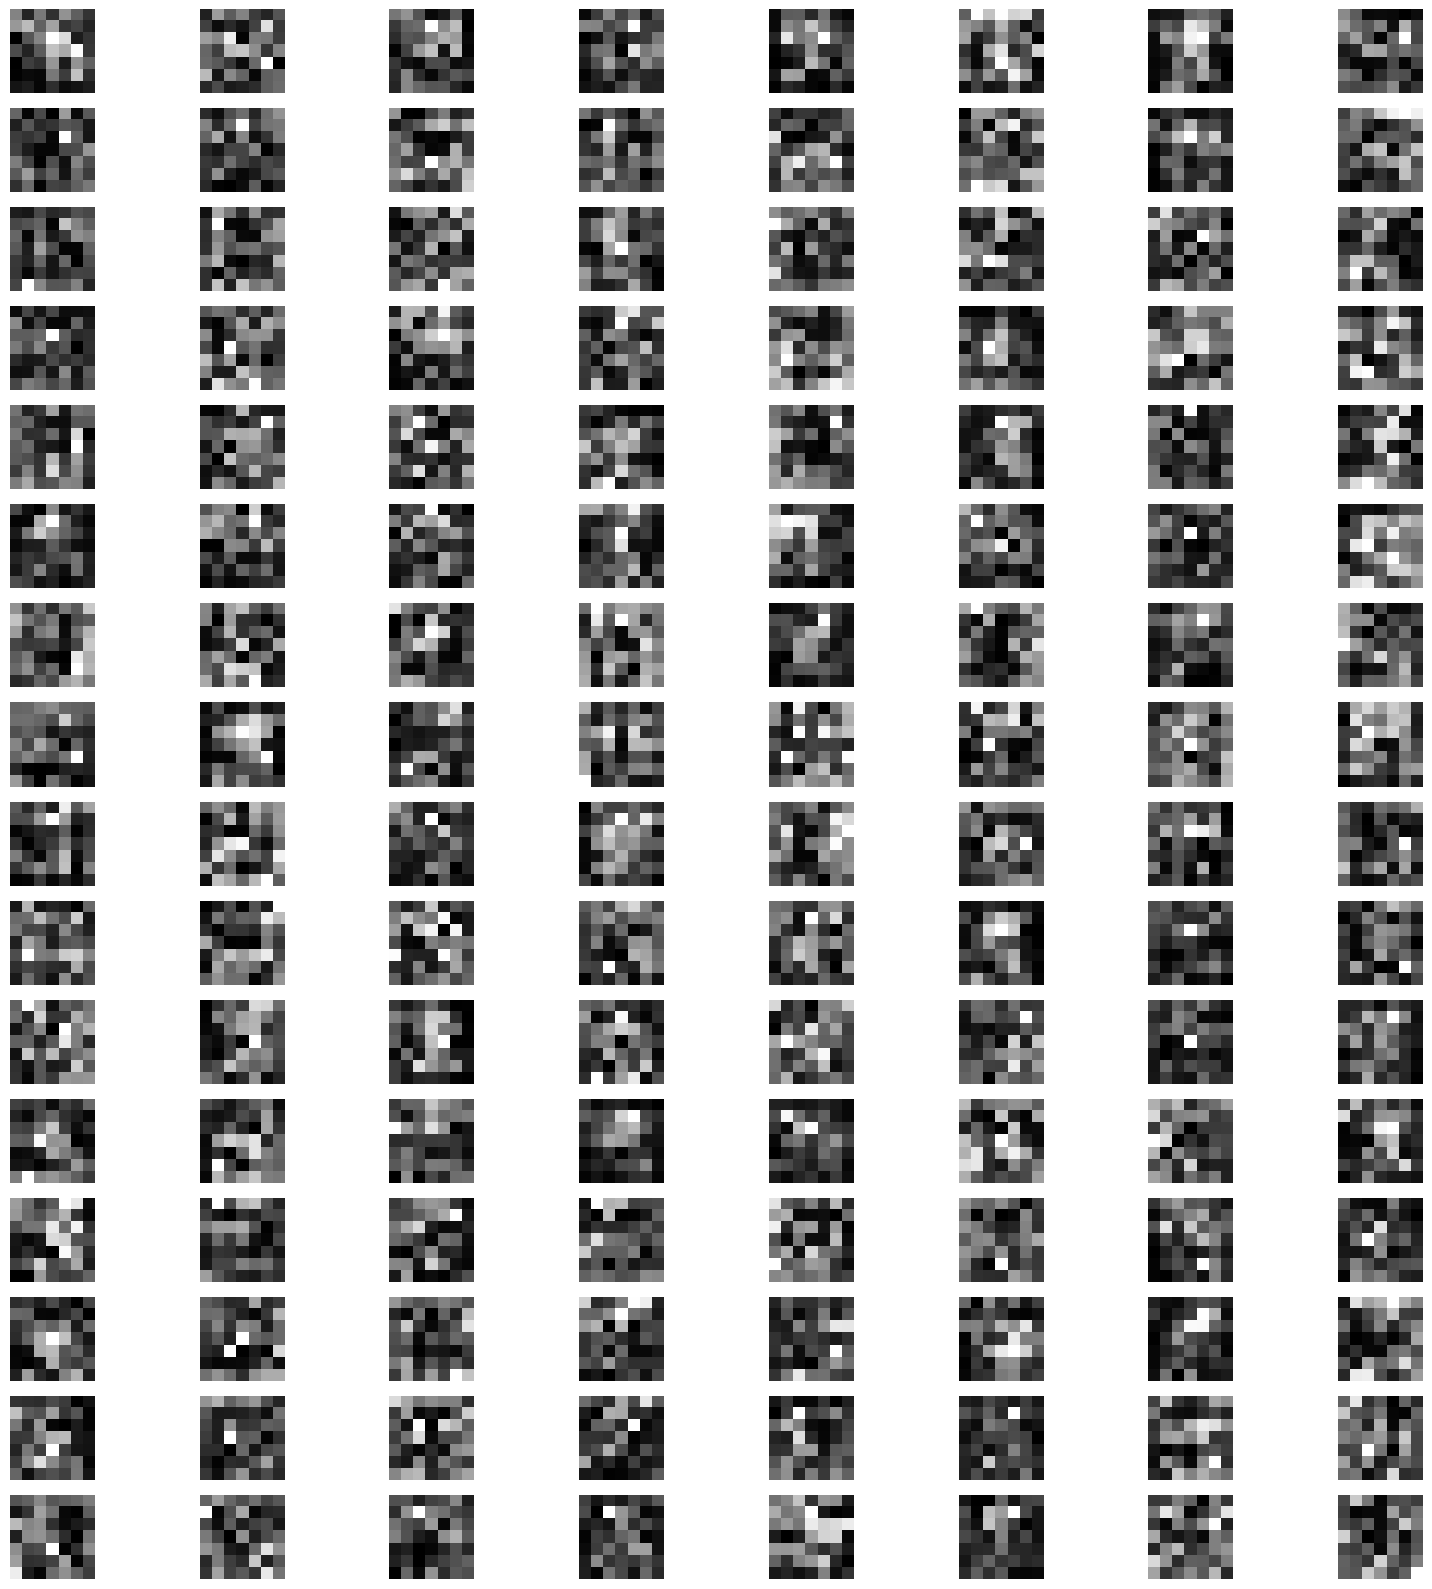

In [20]:
res_conv1 = nn.Sequential(
    nn.Conv2d(n_feat, 2 * n_feat, 3, 1, 1),
    nn.BatchNorm2d(2 * n_feat),
    nn.GELU(),
)
res_conv2 = nn.Sequential(
    nn.Conv2d(2 * n_feat, 2 * n_feat, 3, 1, 1),
    nn.BatchNorm2d(2 * n_feat),
    nn.GELU(),
)
unet_down2 = nn.MaxPool2d(2)

down2 = unet_down2(res_conv2(res_conv1(down1)))
print("down1:", down2.shape)
channel_visualization("", down2)

##### self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

hiddenvec: torch.Size([1, 256, 1, 1])
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


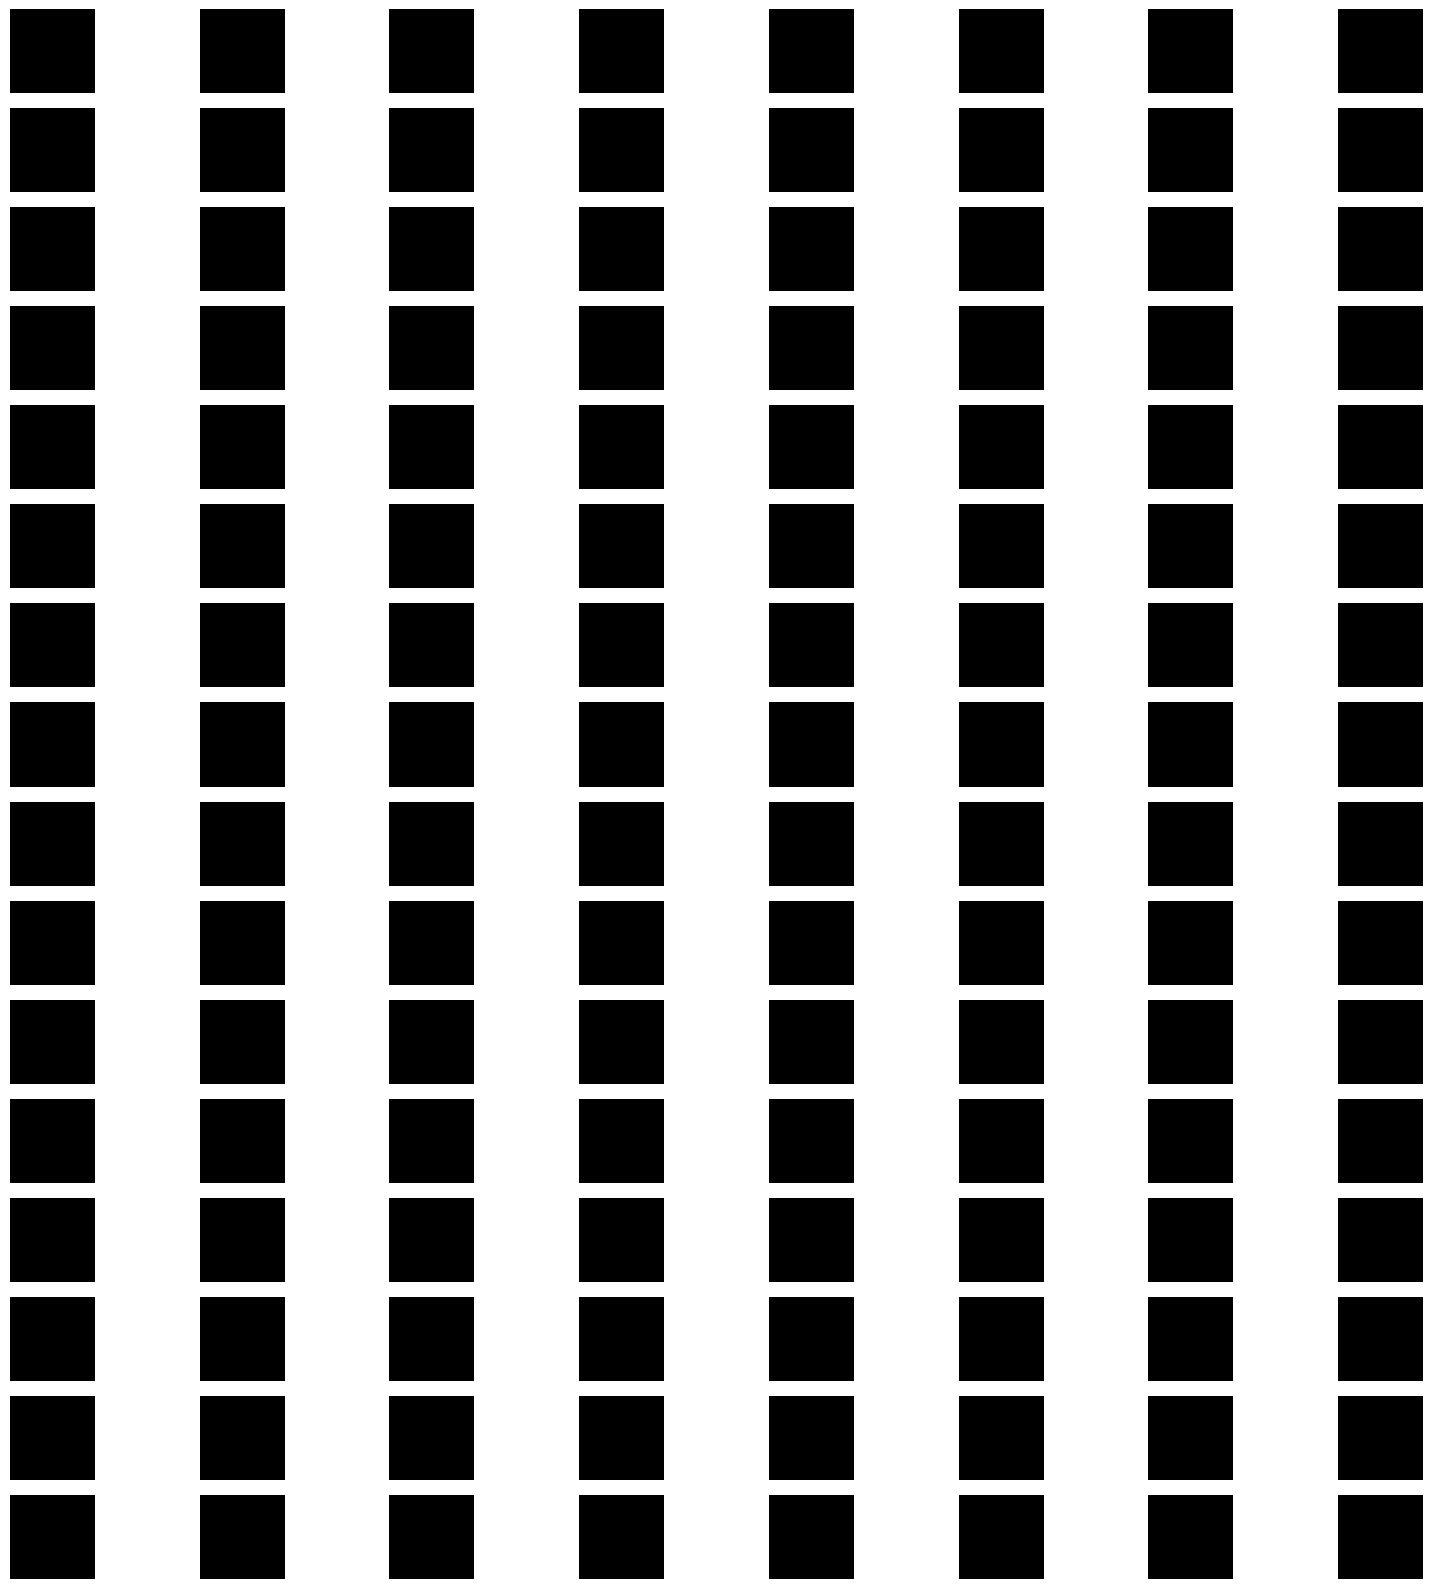

tensor([[[[0.7184]],

         [[0.7304]],

         [[0.7541]],

         [[0.6912]],

         [[0.5934]],

         [[0.6403]],

         [[0.5495]],

         [[0.7159]],

         [[0.6630]],

         [[0.7254]],

         [[0.6887]],

         [[0.6887]],

         [[0.7394]],

         [[0.7019]],

         [[0.7801]],

         [[0.6939]],

         [[0.7501]],

         [[0.5959]],

         [[0.7141]],

         [[0.7284]],

         [[0.6226]],

         [[0.6905]],

         [[0.6421]],

         [[0.6543]],

         [[0.7120]],

         [[0.7384]],

         [[0.7051]],

         [[0.8009]],

         [[0.5215]],

         [[0.6769]],

         [[0.6363]],

         [[0.7424]],

         [[0.7053]],

         [[0.7957]],

         [[0.7175]],

         [[0.6882]],

         [[0.6564]],

         [[0.5905]],

         [[0.7134]],

         [[0.6959]],

         [[0.6853]],

         [[0.7354]],

         [[0.7374]],

         [[0.6563]],

         [[0.6633]],

         [

In [22]:
to_vec = nn.Sequential(
    nn.AvgPool2d(7),
    nn.GELU(),
)

hiddenvec = to_vec(down2)
print("hiddenvec:", hiddenvec.shape)
channel_visualization("", hiddenvec)
print(hiddenvec)

#### EmbedFC

##### self.timeembed1 = EmbedFC(1, 2*n_feat=256)

In [31]:
# _ts = torch.randint(1, n_T+1, (x.shape[0],)) # t ~ Uniform(0, n_T) : 1부터 400까지 균등분포를 따르는 값을 배치차원의 크기로 생성
t = _ts / n_T
print("_ts: ", _ts, "| n_T: ", n_T, "| t(=_ts/n_T): ", t)

_ts:  tensor([100]) | n_T:  400 | t(=_ts/n_T):  tensor([0.2500])


In [37]:
input_dim, emb_dim = 1, 2*n_feat

e1 = nn.Linear(input_dim, emb_dim)
e2 = nn.GELU()
e3 = nn.Linear(emb_dim, emb_dim)

print("t.shape:", t.shape)
t1_view = t.view(-1, input_dim)
print("t1_view.shape:", t1_view.shape)
t1_embed = e1(t1_view)
print("t1_embed.shape (1 -> 256):", t1_embed.shape)
print(t1_embed)
t1_embed = e2(t1_embed)
print("t1_embed.shape (GELU):", t1_embed.shape)
print(t1_embed)
t1_embed = e3(t1_embed)
print("t1_embed.shape (256 -> 256):", t1_embed.shape)
print(t1_embed)

temb1 = t1_embed.view(-1, n_feat * 2, 1, 1)
print("temb1.shape:", temb1.shape)

t.shape: torch.Size([1])
t1_view.shape: torch.Size([1, 1])
t1_embed.shape (1 -> 256): torch.Size([1, 256])
tensor([[ 0.5738, -0.3911,  0.5200, -0.8391,  0.8677,  0.2749,  0.2828,  0.0337,
          0.1516,  0.9467, -0.7494, -0.8070,  0.6071, -0.6705,  0.0297, -1.0382,
          0.9239,  0.0745,  0.0530, -0.5589, -0.6083, -0.4409,  0.2578,  0.8943,
         -0.0081, -0.0743, -0.7286,  0.5555, -1.0180,  0.6255,  1.1078,  0.4854,
         -1.0479, -0.9917,  0.8413, -0.4900, -0.5177,  0.2469, -0.6515, -0.0437,
         -0.0191,  0.2898, -0.4767, -0.7887,  0.1561, -1.2436, -0.3200, -0.1513,
         -1.0160,  0.2936, -0.3544, -0.3409, -1.0345,  0.2095,  0.8943,  0.8924,
         -0.7308, -0.1024,  0.5361, -0.2202, -0.1815, -0.8808,  0.0837, -0.9969,
          0.6837,  0.4244,  0.9082,  0.2798,  0.3014, -0.2429,  0.2166, -0.7711,
         -0.1399, -0.8897,  1.1536,  0.7360,  0.1264, -0.1496,  0.6597,  0.5842,
         -0.6266,  0.1757, -0.6636, -0.2623, -0.9061, -0.7044, -0.0478,  0.5056,
  

##### self.timeembed2 = EmbedFC(1, 1*n_feat=128)

In [41]:
input_dim, emb_dim = 1, 1*n_feat

e1 = nn.Linear(input_dim, emb_dim)
e2 = nn.GELU()
e3 = nn.Linear(emb_dim, emb_dim)

print("t.shape:", t.shape)
t2_view = t.view(-1, input_dim)
print("t2_view.shape:", t2_view.shape)
t2_embed = e1(t2_view)
print("t2_embed.shape (1 -> 128):", t2_embed.shape)
print(t2_embed)
t2_embed = e2(t2_embed)
print("t2_embed.shape (GELU):", t2_embed.shape)
print(t2_embed)
t2_embed = e3(t2_embed)
print("t2_embed.shape (128 -> 128):", t2_embed.shape)
print(t2_embed)

temb2 = t2_embed.view(-1, n_feat, 1, 1)
print("temb2.shape:", temb2.shape)

t.shape: torch.Size([1])
t2_view.shape: torch.Size([1, 1])
t2_embed.shape (1 -> 128): torch.Size([1, 128])
tensor([[-0.6570, -0.6824,  0.2230,  1.0812,  1.0691,  0.1259, -0.1956, -0.1213,
          0.9438,  0.7392,  0.1629,  0.3002, -0.4454,  0.9763, -0.5211,  0.2226,
         -0.2035, -0.4196, -0.2771,  0.7376,  0.0869,  0.8145,  0.8925, -0.1653,
         -0.5957, -0.2123, -0.2766,  0.6317, -0.0825, -0.7228,  0.8893,  0.4184,
          0.8851, -0.3960,  0.4028, -0.4927, -0.1730,  0.1739,  0.2055,  0.3955,
         -0.1167,  0.3816,  0.6441,  0.0838,  0.4149, -0.9156, -0.7058, -0.7430,
         -0.5145,  0.7106,  0.7408,  0.3418, -0.6989, -0.9732, -0.3909,  0.1878,
          0.6523, -0.3038, -1.0260,  0.1319, -0.5170,  0.2096, -0.5963,  0.3339,
          0.7965,  0.8174,  0.4726,  0.4777, -0.7052, -0.6402, -0.8321, -0.4645,
          1.0919,  0.9241,  0.3325,  0.3804,  0.6758, -0.4278, -0.7164, -0.1934,
         -0.7806,  0.2717,  1.0388, -0.0070, -0.7753, -0.2064, -0.4296,  0.5901,
  

##### self.contextembed1 = EmbedFC(n_classes=10, 2*n_feat=256)


In [43]:
print(c)

tensor([[-0., -0., -0., -0., -0., -1., -0., -0., -0., -0.]])


In [46]:
input_dim, emb_dim = 10, 2*n_feat

e1 = nn.Linear(input_dim, emb_dim)
e2 = nn.GELU()
e3 = nn.Linear(emb_dim, emb_dim)

print("c.shape:", c.shape)
c1_view = c.view(-1, input_dim)
print("c1_view.shape:", c1_view.shape)
c1_embed = e1(c1_view)
print("c1_embed.shape (10 -> 256):", c1_embed.shape)
print(t2_embed)
c1_embed = e2(c1_embed)
print("c1_embed.shape (GELU):", c1_embed.shape)
print(t2_embed)
c1_embed = e3(c1_embed)
print("c1_embed.shape (256 -> 256):", c1_embed.shape)
print(c1_embed)

cemb1 = c1_embed.view(-1, n_feat * 2, 1, 1)
print("cemb1.shape:", cemb1.shape)

c.shape: torch.Size([1, 10])
c1_view.shape: torch.Size([1, 10])
c1_embed.shape (10 -> 256): torch.Size([1, 256])
tensor([[ 4.1173e-01, -1.8014e-01, -9.7546e-02, -1.3393e-01,  2.1522e-02,
          1.5912e-01,  1.6766e-01,  3.9107e-01, -1.7269e-01,  4.0422e-01,
          2.0691e-01,  2.0992e-01,  2.3688e-02, -8.8324e-02,  3.9218e-02,
          2.1747e-01,  4.5442e-01, -3.2424e-01, -1.8386e-01, -2.2771e-01,
          7.8092e-02, -2.4323e-01, -8.1460e-02, -1.5075e-01,  4.1069e-01,
          3.2271e-01, -1.5589e-01,  2.0344e-01, -3.4061e-02, -1.1462e-01,
          5.3851e-03,  7.0410e-02,  1.3682e-01,  7.4375e-01,  4.8064e-02,
          1.4990e-01, -1.3008e-01,  2.4608e-01, -6.9049e-02,  1.9202e-01,
          1.8737e-01,  1.0133e-01, -2.4015e-02, -3.9214e-01,  1.8840e-02,
          1.7776e-01, -1.7974e-01, -4.7963e-02,  2.0622e-01,  6.6294e-02,
          8.6003e-02,  2.1745e-01,  4.9597e-02, -5.0068e-02,  1.8389e-01,
         -1.7953e-01, -1.1638e-01,  1.8434e-02, -4.0900e-01, -2.3415e-01,

##### self.contextembed2 = EmbedFC(n_classes=10, 1*n_feat=128)


In [47]:
input_dim, emb_dim = 10, 1*n_feat

e1 = nn.Linear(input_dim, emb_dim)
e2 = nn.GELU()
e3 = nn.Linear(emb_dim, emb_dim)

print("c.shape:", c.shape)
c2_view = c.view(-1, input_dim)
print("c2_view.shape:", c2_view.shape)
c2_embed = e1(c2_view)
print("c2_embed.shape (10 -> 128):", c2_embed.shape)
print(t2_embed)
c2_embed = e2(c2_embed)
print("c1_embed.shape (GELU):", c2_embed.shape)
print(t2_embed)
c2_embed = e3(c2_embed)
print("c1_embed.shape (128 -> 128):", c2_embed.shape)
print(c1_embed)

cemb2 = c1_embed.view(-1, n_feat * 2, 1, 1)
print("cemb2.shape:", cemb2.shape)

c.shape: torch.Size([1, 10])
c2_view.shape: torch.Size([1, 10])
c2_embed.shape (10 -> 128): torch.Size([1, 128])
tensor([[ 4.1173e-01, -1.8014e-01, -9.7546e-02, -1.3393e-01,  2.1522e-02,
          1.5912e-01,  1.6766e-01,  3.9107e-01, -1.7269e-01,  4.0422e-01,
          2.0691e-01,  2.0992e-01,  2.3688e-02, -8.8324e-02,  3.9218e-02,
          2.1747e-01,  4.5442e-01, -3.2424e-01, -1.8386e-01, -2.2771e-01,
          7.8092e-02, -2.4323e-01, -8.1460e-02, -1.5075e-01,  4.1069e-01,
          3.2271e-01, -1.5589e-01,  2.0344e-01, -3.4061e-02, -1.1462e-01,
          5.3851e-03,  7.0410e-02,  1.3682e-01,  7.4375e-01,  4.8064e-02,
          1.4990e-01, -1.3008e-01,  2.4608e-01, -6.9049e-02,  1.9202e-01,
          1.8737e-01,  1.0133e-01, -2.4015e-02, -3.9214e-01,  1.8840e-02,
          1.7776e-01, -1.7974e-01, -4.7963e-02,  2.0622e-01,  6.6294e-02,
          8.6003e-02,  2.1745e-01,  4.9597e-02, -5.0068e-02,  1.8389e-01,
         -1.7953e-01, -1.1638e-01,  1.8434e-02, -4.0900e-01, -2.3415e-01,

#### UnetUp

##### self.up0 = nn.Sequential(
    nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
    nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7), # otherwise just have 2*n_feat
    nn.GroupNorm(8, 2 * n_feat),
    nn.ReLU(),
)

In [49]:
print("hiddenvec.shape:", hiddenvec.shape)

hiddenvec.shape: torch.Size([1, 256, 1, 1])


up1.shape: torch.Size([1, 256, 7, 7])
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0524, 0.0000, 0.0000,  ..., 0.7119, 0.0000, 0.0000],
          [0.0000, 0.0873, 0.0000,  ..., 0.0000, 0.0000, 0.2056],
          ...,
          [0.0000, 0.3243, 1.6864,  ..., 0.0000, 0.0000, 1.5262],
          [0.9796, 0.3400, 0.0000,  ..., 1.0855, 0.0000, 0.0954],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0299, 0.0000]],

         [[1.2155, 0.4325, 0.0000,  ..., 0.4987, 0.0000, 0.7368],
          [0.0000, 0.0771, 0.4449,  ..., 0.8617, 0.0000, 1.3173],
          [0.6215, 0.6424, 0.0740,  ..., 0.0000, 0.0000, 1.0459],
          ...,
          [0.0000, 0.7508, 0.5408,  ..., 1.0439, 0.0000, 0.0000],
          [0.3089, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.4449, 0.0000, 0.0000,  ..., 0.6851, 0.0000, 0.7290]],

         [[0.0000, 0.0000, 1.3830,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.1474],
    

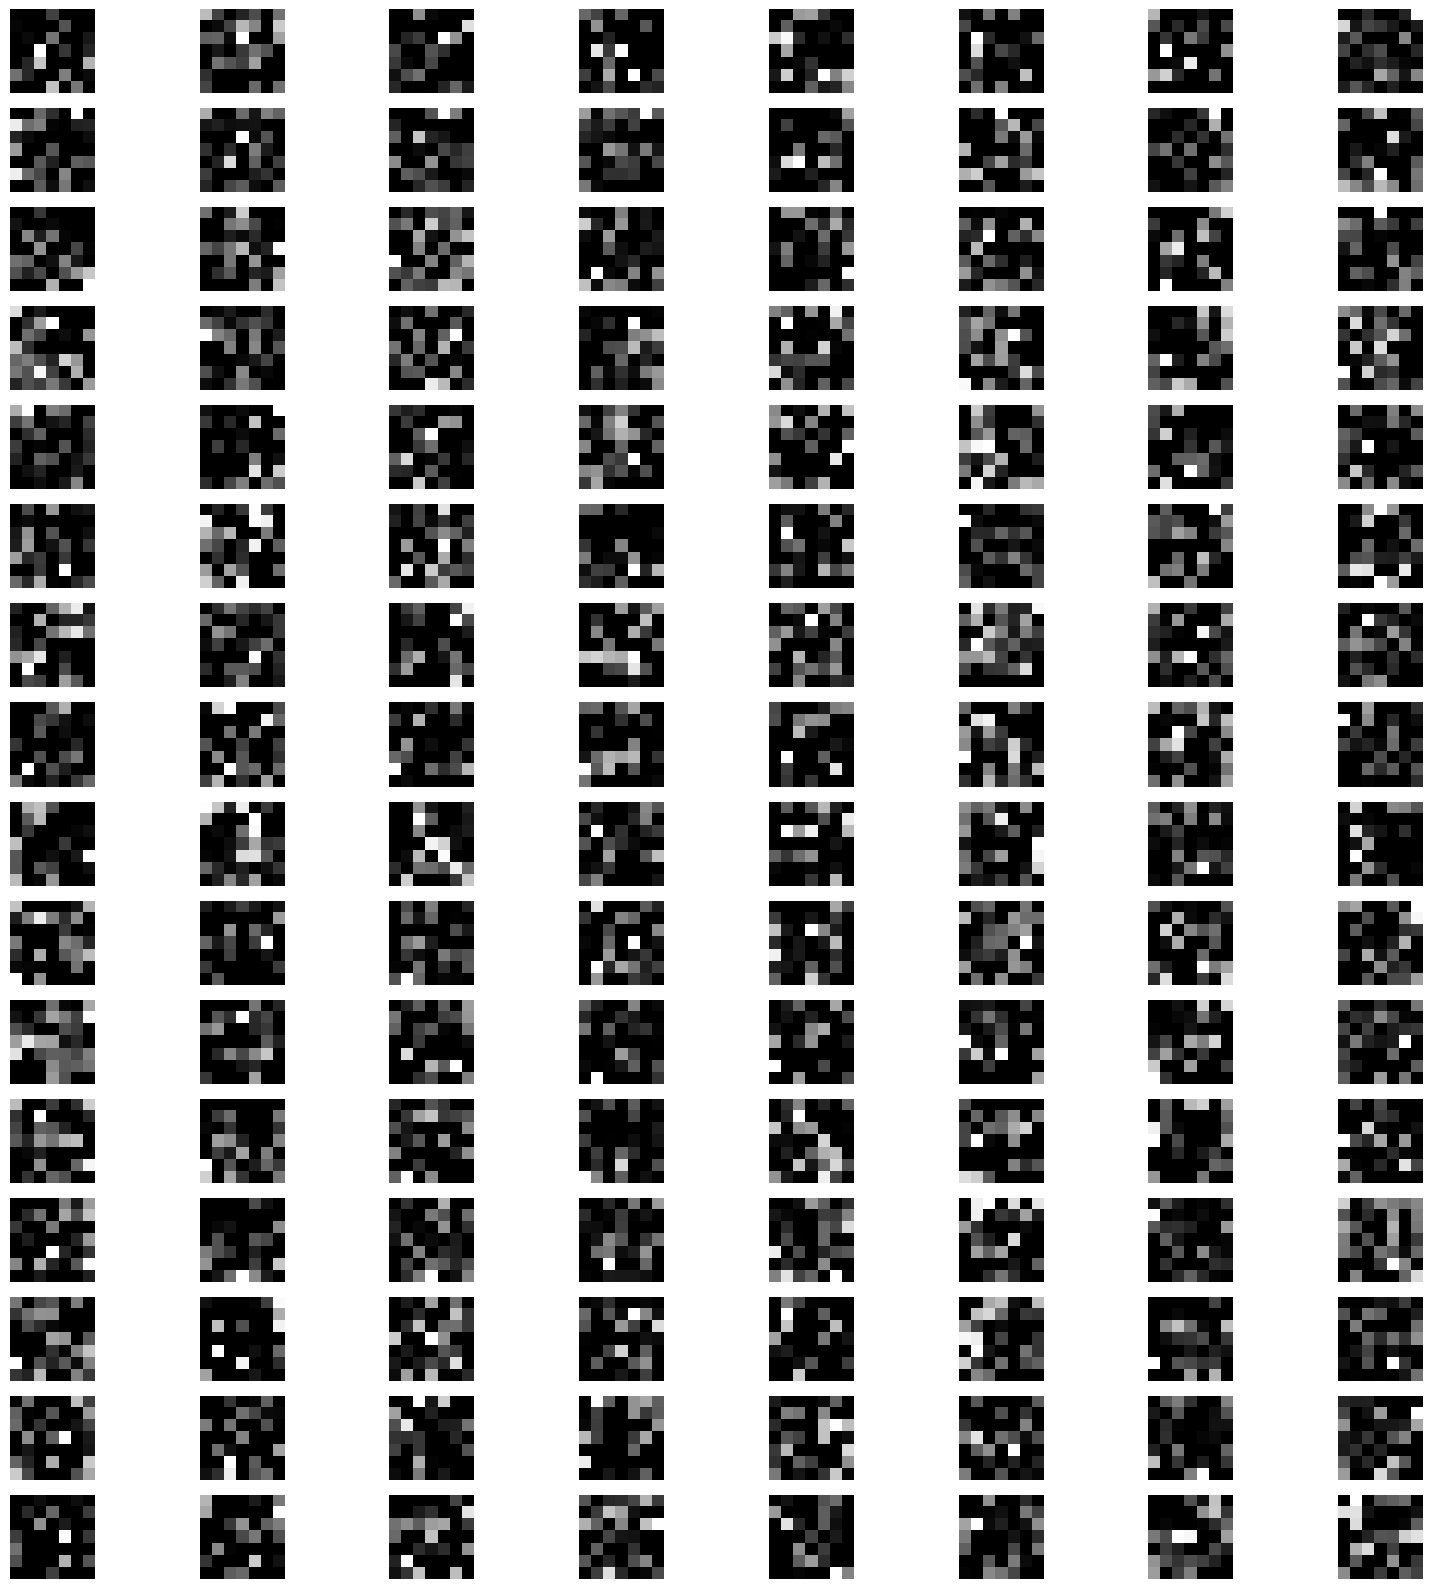

In [55]:
up0_m1 = nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7) # 256, 256, 7, 7
up0_m2 = nn.GroupNorm(8, 2 * n_feat) # 8, 256
up0_m3 = nn.ReLU()

up1 = up0_m1(hiddenvec)
up1 = up0_m2(up1)
up1 = up0_m3(up1)

print("up1.shape:", up1.shape)
print(up1)

channel_visualization("", up1)

##### self.up1 = UnetUp(4 * n_feat = 512, n_feat)

cemb1*up1.shape: torch.Size([1, 256, 7, 7])
cemb1*up1: tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0061,  0.0000,  0.0000,  ...,  0.0834,  0.0000,  0.0000],
          [ 0.0000,  0.0102,  0.0000,  ...,  0.0000,  0.0000,  0.0241],
          ...,
          [ 0.0000,  0.0380,  0.1975,  ...,  0.0000,  0.0000,  0.1787],
          [ 0.1147,  0.0398,  0.0000,  ...,  0.1271,  0.0000,  0.0112],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.1206,  0.0000]],

         [[-0.0281, -0.0100, -0.0000,  ..., -0.0115, -0.0000, -0.0170],
          [-0.0000, -0.0018, -0.0103,  ..., -0.0199, -0.0000, -0.0304],
          [-0.0143, -0.0148, -0.0017,  ..., -0.0000, -0.0000, -0.0241],
          ...,
          [-0.0000, -0.0173, -0.0125,  ..., -0.0241, -0.0000, -0.0000],
          [-0.0071, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
          [-0.0103, -0.0000, -0.0000,  ..., -0.0158, -0.0000, -0.0168]],

         [[-0.0000, -0.0000, -0.1993,  ..., -0.

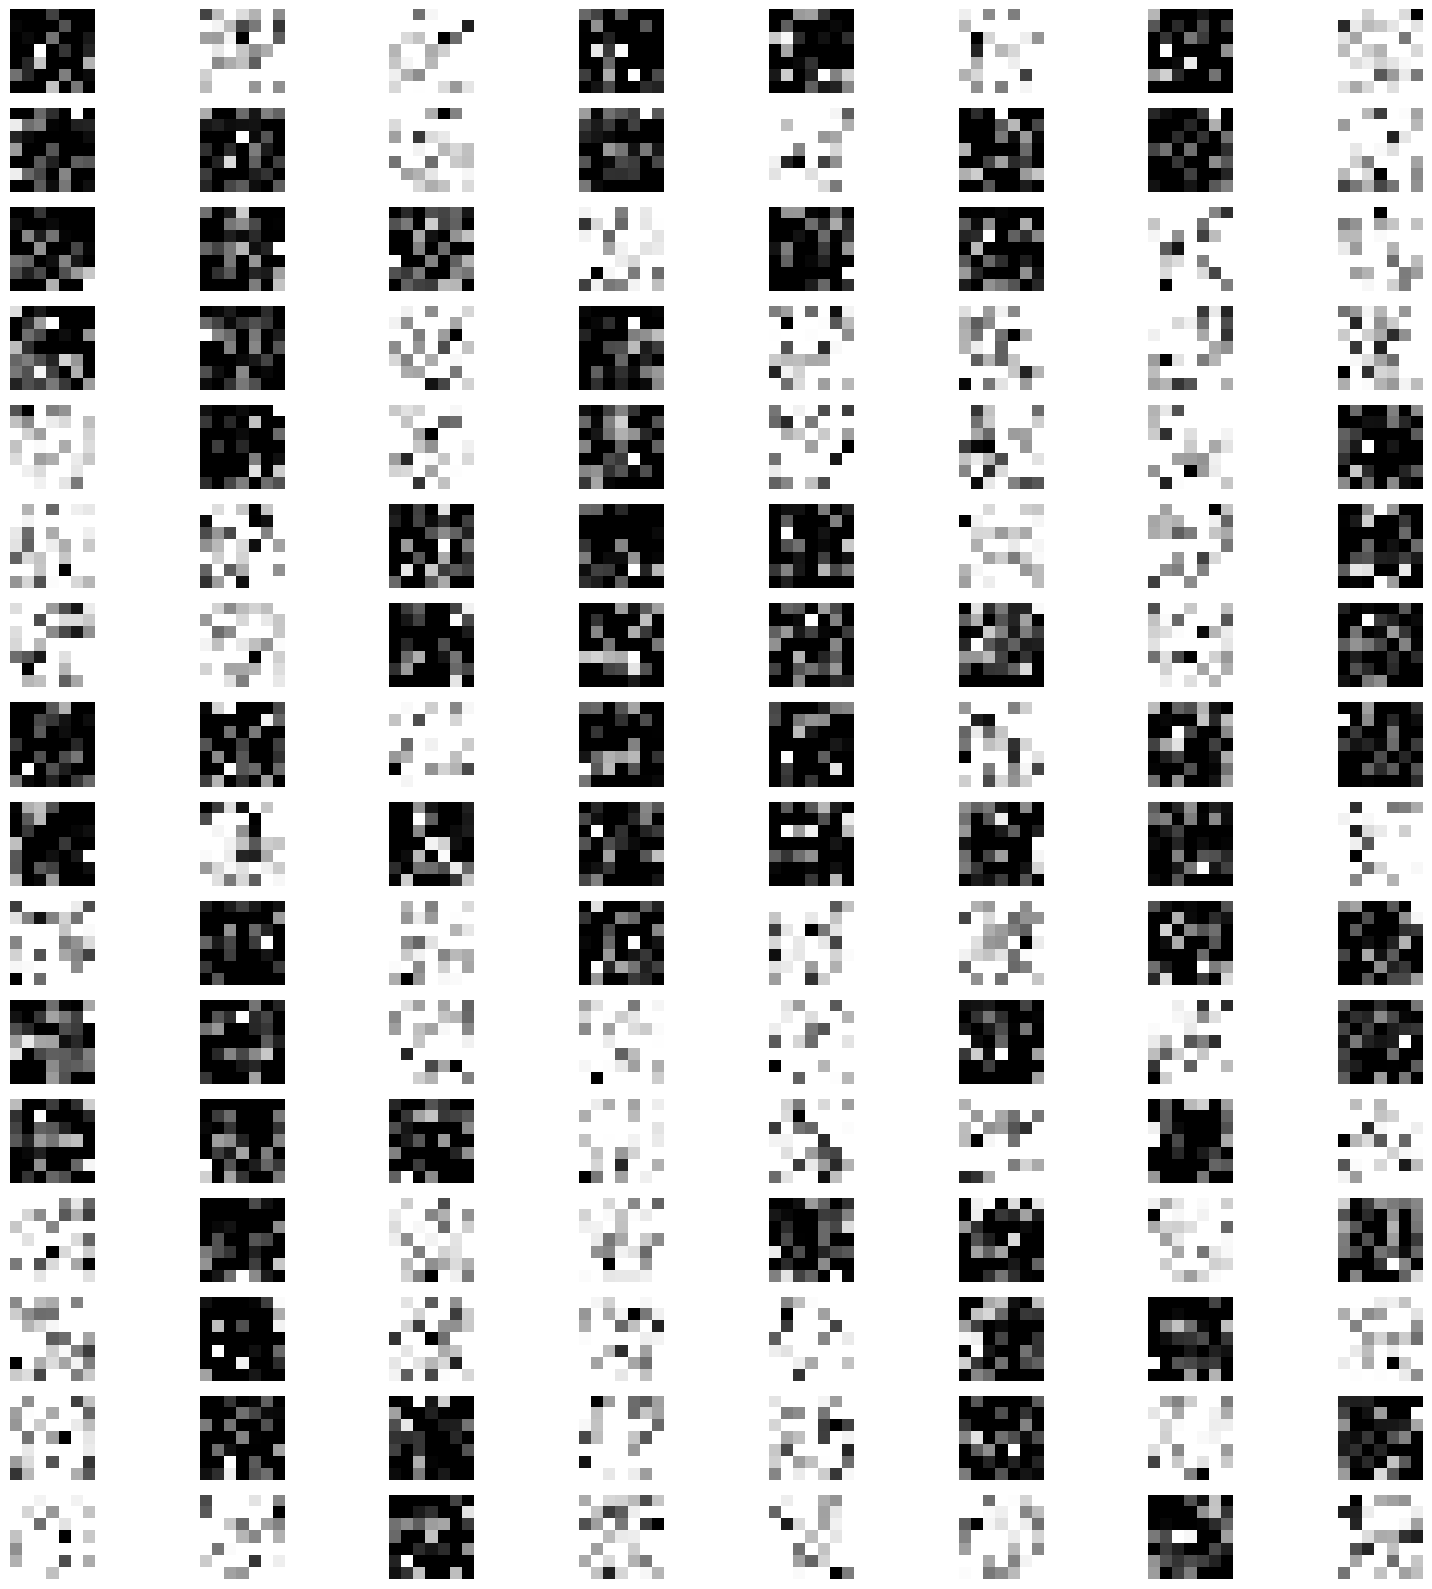

torch.cat((up1_x, skip), 1).shape: torch.Size([1, 512, 7, 7])


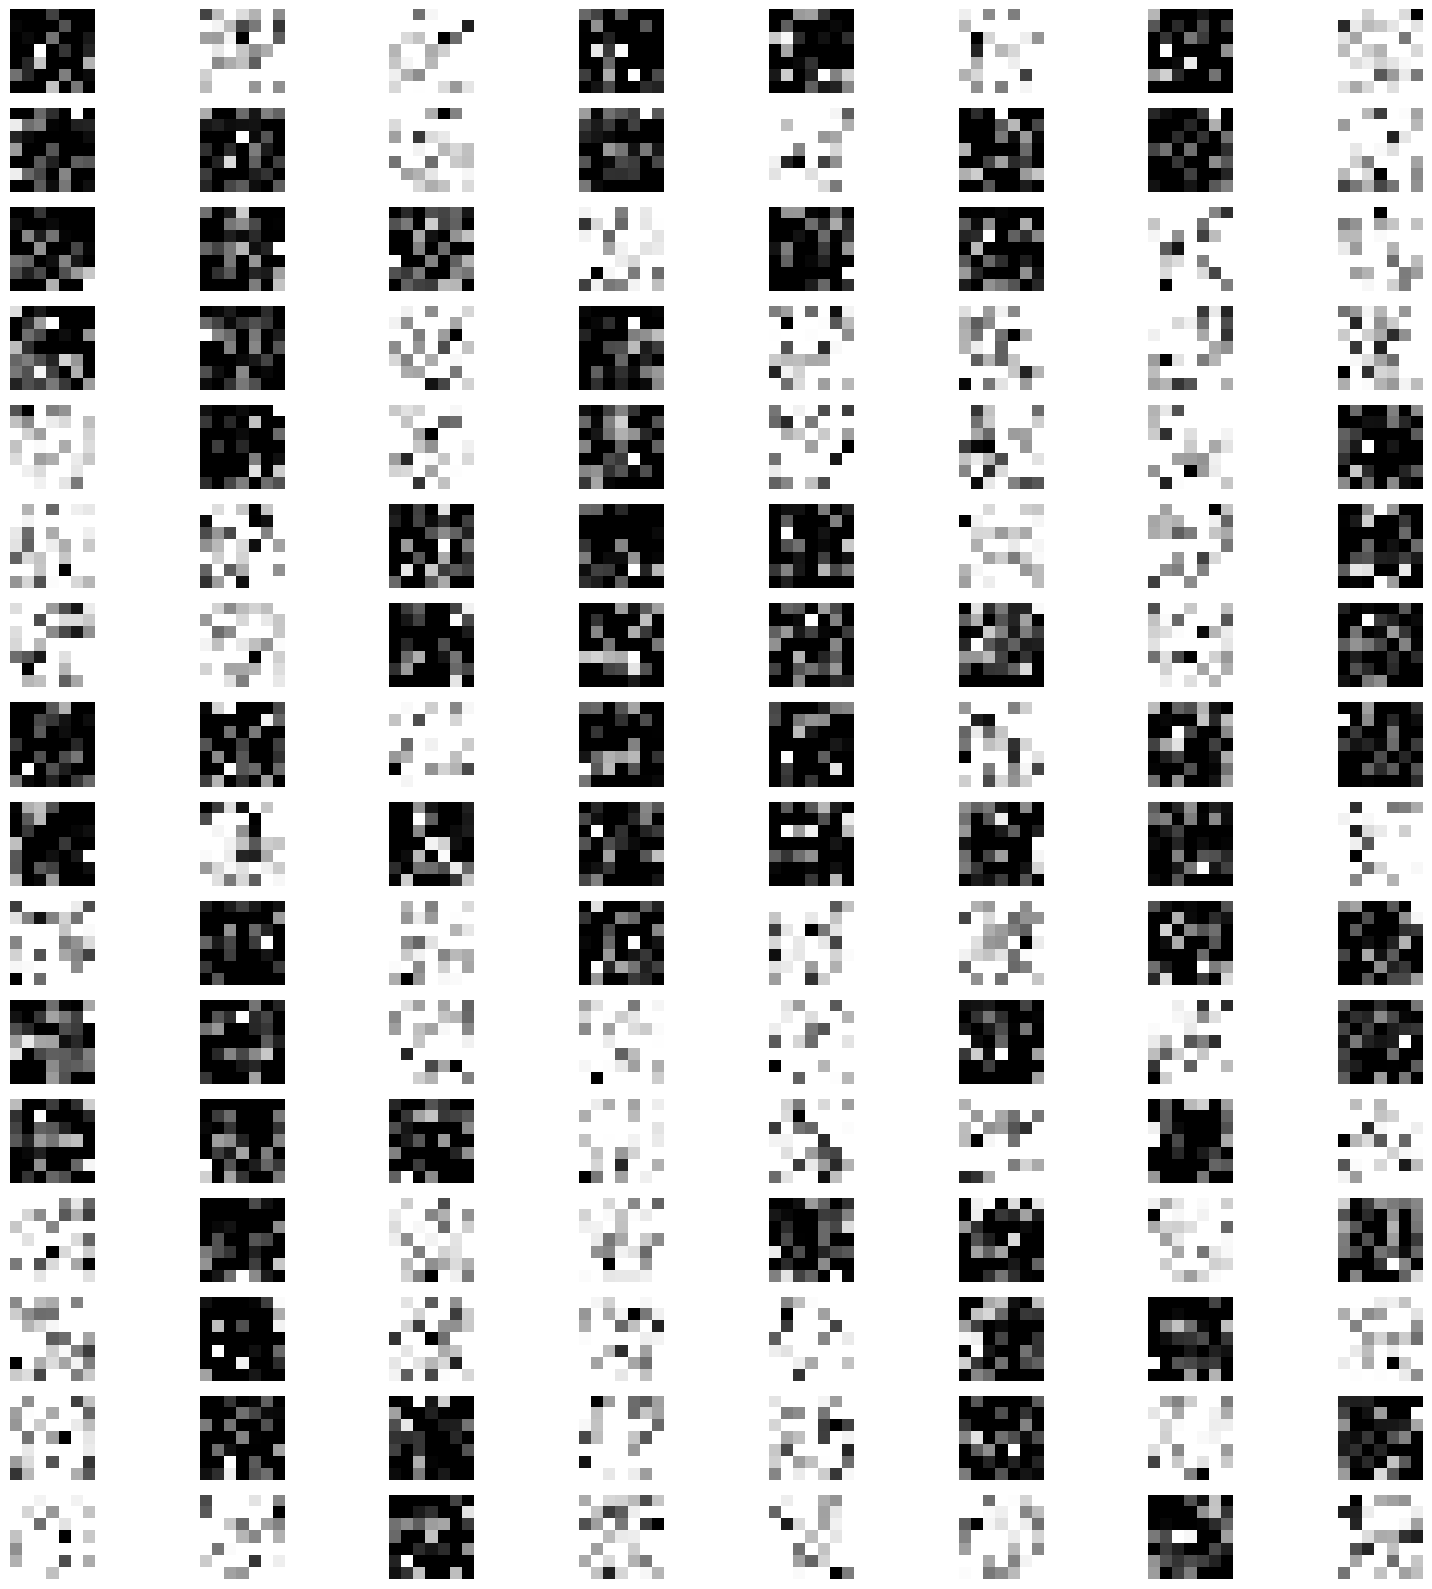

up2 passed layer: tensor([[[[ 2.2107e-01,  2.2107e-01,  2.2107e-01,  ...,  2.2107e-01,
            2.2107e-01,  2.2107e-01],
          [ 2.2720e-01,  2.2107e-01,  2.2107e-01,  ...,  3.0443e-01,
            2.2107e-01,  2.2107e-01],
          [ 2.2107e-01,  2.3129e-01,  2.2107e-01,  ...,  2.2107e-01,
            2.2107e-01,  2.4515e-01],
          ...,
          [ 2.2107e-01,  2.5904e-01,  4.1854e-01,  ...,  2.2107e-01,
            2.2107e-01,  3.9978e-01],
          [ 3.3578e-01,  2.6088e-01,  2.2107e-01,  ...,  3.4817e-01,
            2.2107e-01,  2.3224e-01],
          [ 2.2107e-01,  2.2107e-01,  2.2107e-01,  ...,  2.2107e-01,
            3.4167e-01,  2.2107e-01]],

         [[-2.3245e-01, -2.1437e-01, -2.0439e-01,  ..., -2.1590e-01,
           -2.0439e-01, -2.2140e-01],
          [-2.0439e-01, -2.0617e-01, -2.1466e-01,  ..., -2.2428e-01,
           -2.0439e-01, -2.3480e-01],
          [-2.1874e-01, -2.1922e-01, -2.0610e-01,  ..., -2.0439e-01,
           -2.0439e-01, -2.2854e-01],
  

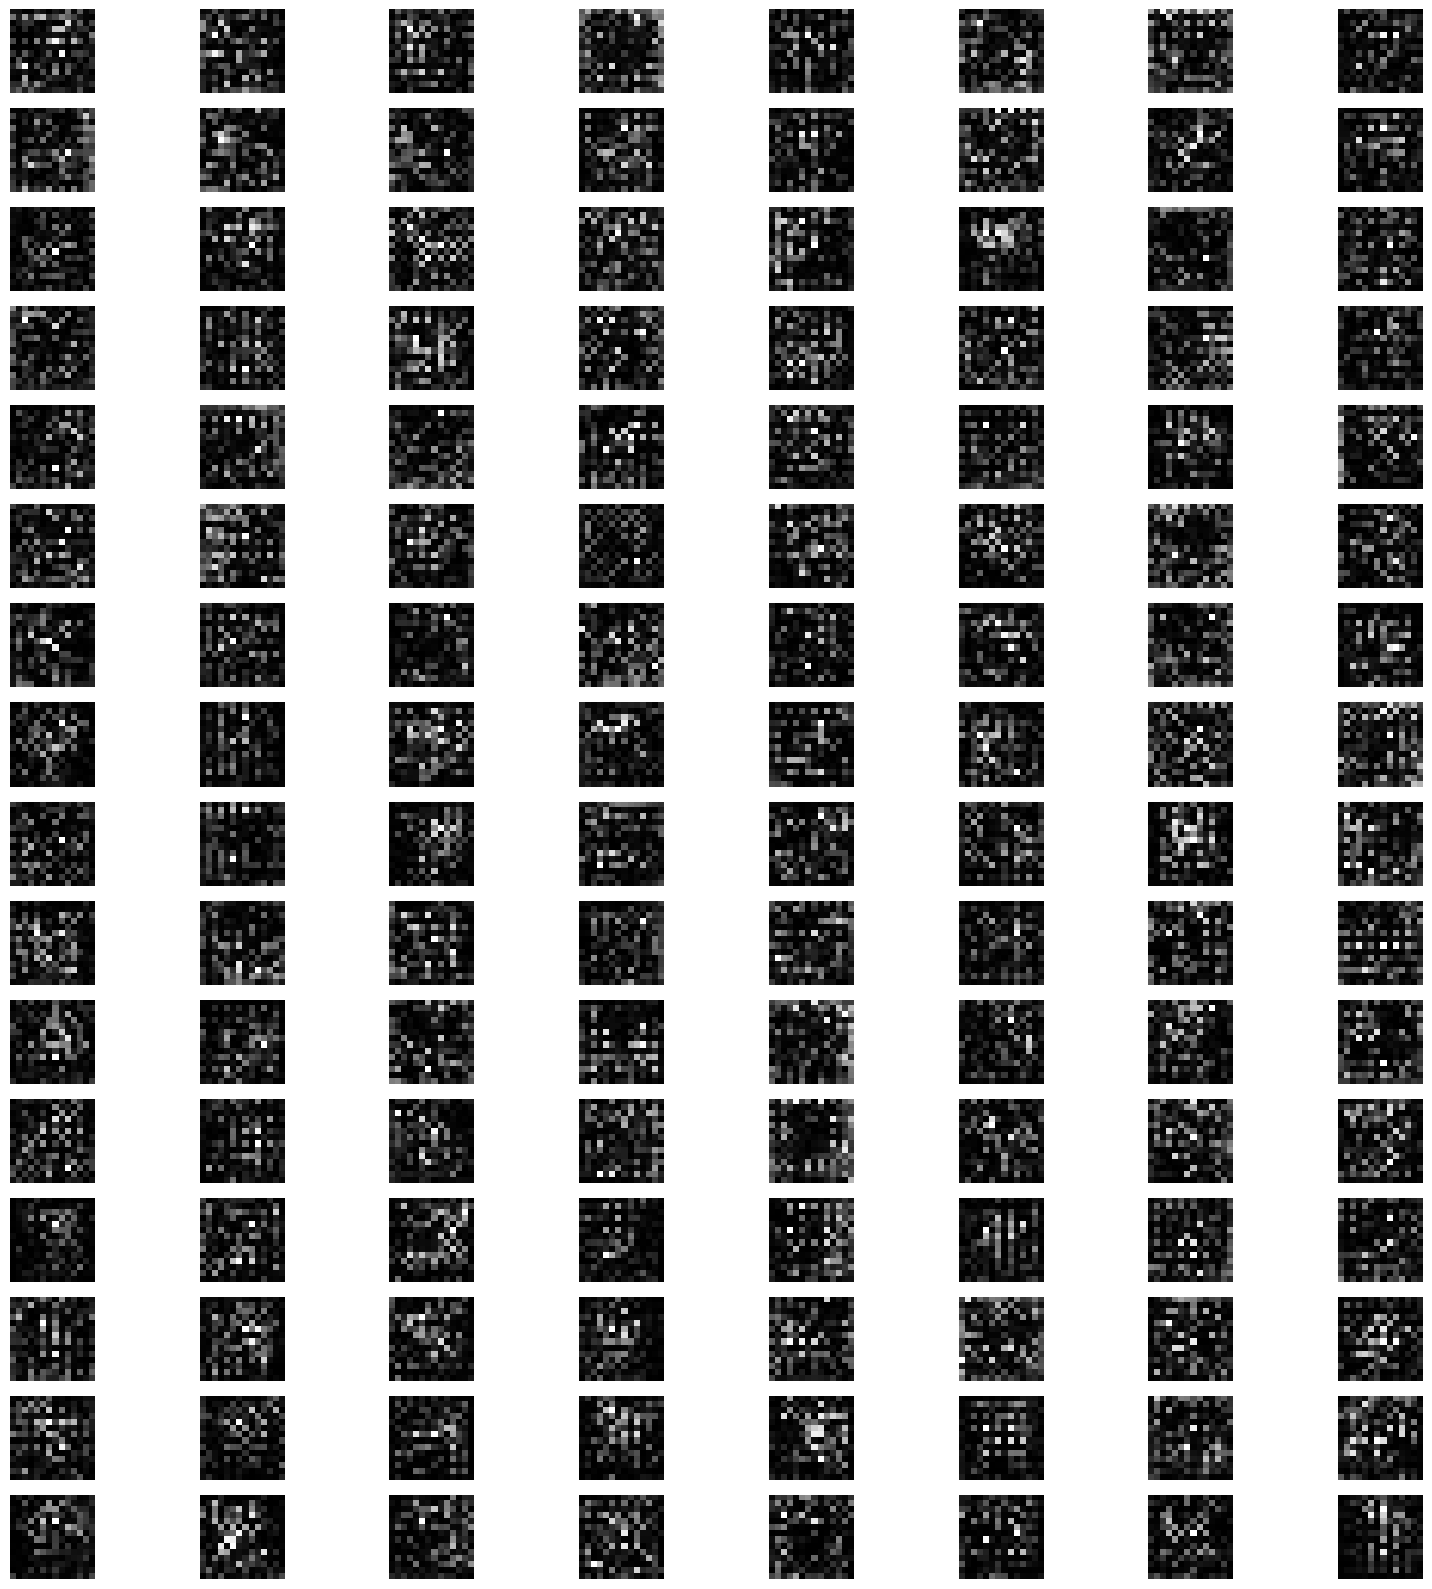

In [64]:
in_channels, out_channels = 4 * n_feat, n_feat
up1_x = cemb1*up1 + temb1
skip = down2
print("cemb1*up1.shape:", (cemb1*up1).shape)
print("cemb1*up1:",cemb1*up1)
print("cemb1*up1 + temb1:",up1_x)
print("up1_x (=cemb1*up1 + temb1):",up1_x.shape)
channel_visualization("", up1_x)

up1_m1 = nn.ConvTranspose2d(in_channels, out_channels, 2, 2)
up1_m2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
up1_m3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

print("torch.cat((up1_x, skip), 1).shape:", torch.cat((up1_x, skip), 1).shape)
up2 = torch.cat((up1_x, skip), 1)
channel_visualization("", up2)
print("up2 passed layer:", up2)
up2 = up1_m3(up1_m2(up1_m1(up2)))
channel_visualization("", up2)


##### self.up2 = UnetUp(2 * n_feat, n_feat)

##### self.out = nn.Sequential(
     nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
     nn.GroupNorm(8, n_feat),
     nn.ReLU(),
     nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
 )

5
torch.Size([1, 28, 28])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.000

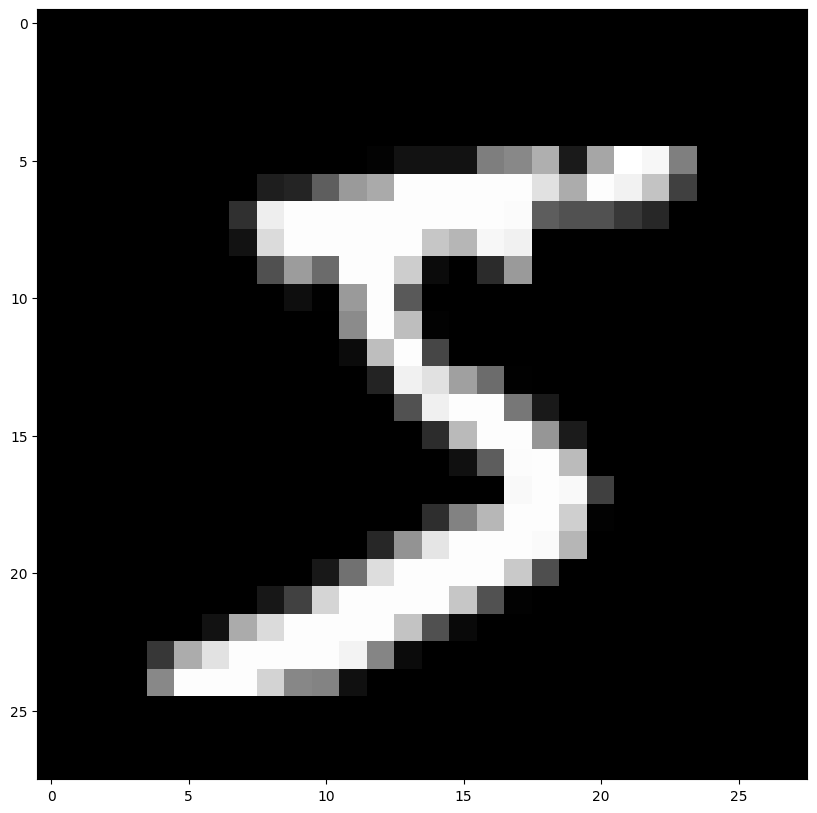

In [49]:
# Visualization

print(mnist_dataset[0][1]) # label
print(mnist_dataset[0][0].shape) # shape of tensor
print(mnist_dataset[0][0]) # tensor

plt.figure(figsize=(10,10))
plt.imshow(to_pil_image(mnist_dataset[0][0]), cmap='gray')

### Distribution of the Training Data

### Distribution of the Model's Output